# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import talib
from matplotlib.ticker import PercentFormatter
import statsmodels.api as sm
import seaborn as sns
import pytz
from tabulate import tabulate
import mplfinance as mpf
from scipy.stats import linregress
from scipy import stats
from datetime import datetime
import os
import sys
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import scipy.stats as stats

# This is how funtions are usually imported, which is unnecessary for this notebook, as functions are already in the code
sys.path.append(os.path.abspath("../functions"))
from function import *

# Data preparation

In [ ]:
#SECTION - preparing data
# We have to prepare data for future usage, this dataframe will be used for calculating precise entry/exit points, as well as exact time of transaction
file_path = os.path.join('..', 'data', 'nasdaq', '20082024.txt')
df_1m = pd.read_csv(file_path, header=None, parse_dates=[0], names=['timestamp', 'open', 'high', 'low', 'close', 'Volume'])
df_1m.drop(columns=['Volume'], inplace=True)

# Filtering 5 years of data for initial backtest
df_1m = df_1m[df_1m['timestamp'].dt.year >= 2018]
df_1m = df_1m[df_1m['timestamp'].dt.year <= 2022]

# Changing timezone to UTC+1
us_eastern = pytz.timezone('America/New_York')
utc_plus_one = pytz.timezone('Europe/Warsaw')
df_1m['timestamp'] = pd.to_datetime(df_1m['timestamp']).dt.tz_localize(us_eastern).dt.tz_convert(utc_plus_one)

# Formatting timestamp column to correct format
df_1m['timestamp'] = df_1m['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_1m['timestamp'] = pd.to_datetime(df_1m['timestamp'])
df_1m.dropna(inplace=True)
df_1m.reset_index(inplace=True)

# We are also preparing data frame for the rest of the backtest, it has already been prepared and saved in csv, as it is used in other scripts, it contains agrragated data for 5 minutes candles, as well as some additional precalculated columns
file_path = os.path.join('..', 'data', 'nasdaq', 'nasdaq20182022_5m.txt')
df = pd.read_csv(file_path, parse_dates=[0])
df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
df['timestamp'] = pd.to_datetime(df['timestamp'])
#!SECTION

# This is one of the functions already used on the data, it calculates possible entry points for future calculations 
#SECTION - calculating demand zones
def calculate_ob_fvg(df, taller_than_ob_by=2):
    # taller_than_ob_by argument is used to avoid signals that we might not be able to catch, because they will get triggered too quickly
    df['demand'] = 0
    df['number_of_candles'] = 0
    df['past_15'] = 0
    for i in range(1000, len(df) - 1):
        timestamp = df['timestamp'][i]
        if timestamp.hour > 15 or (timestamp.hour == 15 and timestamp.minute >= 30) and timestamp.hour < 23:
            df.at[i, 'past_15'] = 1
        if df.at[i, 'open'] > df.at[i, 'close']:
            for j in range(i + 1, len(df) - 1):
                if df.at[j, 'close'] > df.at[j, 'open']:
                    if df.at[j, 'close'] > df.at[i, 'high'] + taller_than_ob_by:
                        df.at[i, 'demand'] = 1
                        df.at[i, 'number_of_candles'] = j
                        break
                else:
                    break
    return df
#!SECTION

# Algorithm


In [ ]:
# We save index of demand zones, as we will iterate over them to find possible trades, we also only take into consideration zones past 15:30
demand_index = df[(df['demand'] == 1) & df['past_15'] == 1].index
trade_number = 1
final_results = pd.DataFrame()
start_time = datetime.now()

for structure_index in demand_index:

    filled_after_0 = None
    filled_after_1 = None
    filled_after_2 = None
    taller_than_demand_by = 2

    #SECTION - demand selection
    # We have calculated demand zones with previous function, now we are calculating how many candles it consists of and when it becomes a valid structure as well as when it will be triggered
    if df.at[structure_index-1, 'open'] > df.at[structure_index-1, 'close']:
        if df.at[structure_index-2, 'open'] > df.at[structure_index-2, 'close']:
            entry_price_2 = max(df.at[structure_index-2, 'high'], df.at[structure_index-1, 'high'], df.at[structure_index, 'high'])
            stop_loss_2 = min(df.at[structure_index-2, 'low'], df.at[structure_index-1, 'low'], df.at[structure_index, 'low'], df.at[structure_index+1, 'low'])
            for j in range(structure_index+1, len(df)-1):
                if df.at[j, 'close'] > df.at[j, 'open']:
                    if df.at[j, 'close'] > entry_price_2+taller_than_demand_by:
                        demand_after_2 = j
                        demand_body_2 = df.at[structure_index-2, 'open'] - df.at[structure_index, 'close']
                        break
            for j in range(demand_after_2+1, len(df)):
                if df.loc[j, 'low'] <= entry_price_2:
                    filled_after_2 = j
                    break
        entry_price_1 = max(df.at[structure_index-1, 'high'], df.at[structure_index, 'high'])
        stop_loss_1 = min(df.at[structure_index-1, 'low'], df.at[structure_index, 'low'], df.at[structure_index+1, 'low'])
        for j in range(structure_index+1, len(df)-1):
            if df.at[j, 'close'] > df.at[j, 'open']:
                if df.at[j, 'close'] > entry_price_1+taller_than_demand_by:
                    demand_after_1 = j
                    demand_body_1 = df.at[structure_index-1, 'open'] - df.at[structure_index, 'close']
                    break
        for j in range(demand_after_1+1, len(df)):
            if df.loc[j, 'low'] <= entry_price_1:
                filled_after_1 = j
                break
    

    entry_price_0 = df.at[structure_index, 'high']
    stop_loss_0 = min(df.at[structure_index, 'low'], df.at[structure_index+1, 'low'])
    demand_after_0 = df.at[structure_index, 'number_of_candles']
    demand_body_0 = df.at[structure_index, 'open'] - df.at[structure_index, 'close']
    for j in range(demand_after_0+1, len(df)):
        if df.loc[j, 'low'] <= entry_price_0:
            filled_after_0 = j
            break

    #  We are choosing the most recent demand zone, as it is the most relevant
    filled_vars = [var for var in [filled_after_0, filled_after_1, filled_after_2] if var is not None]
    if filled_vars:
        entry_index = min(filled_vars)
        if entry_index == filled_after_2:
            entry_price = entry_price_2
            stop_loss = stop_loss_2  
            demand_after = demand_after_2
            demand_body = demand_body_2
            number_of_candles = 3
        elif entry_index == filled_after_1:
            entry_price = entry_price_1
            stop_loss = stop_loss_1
            demand_after = demand_after_1
            demand_body = demand_body_1
            number_of_candles = 2
        else:
            entry_price = entry_price_0
            stop_loss = stop_loss_0
            demand_after = demand_after_0
            demand_body = demand_body_0
            number_of_candles = 1
    else:
        continue

    # We are filtering out trades that are too close to midnight, as they might not be executed properly
    if df.at[entry_index, 'timestamp'].hour == 23: 
        continue
    
    # We are filtering out trades that are too small, as they might not be profitable because of spread and fees
    stoploss_size = entry_price - stop_loss
    if stoploss_size < 15:
        continue

    # We are filtering out trades that are too far from the structure, as they might not be relevant, as well as trades that are too close to the structure
    if entry_index - structure_index > 50 or entry_index-structure_index < 3:
        continue
    
    # We create variable to check if trade was filled after midnight, as market conditions might be different
    if df.at[entry_index, 'timestamp'].hour < 15:
        filled_after_midnight = 1
    else:
        filled_after_midnight = 0

    # We are filtering out trades that are filled on market open, as they might not be executed properly
    if df.at[entry_index, 'open'] < entry_price:
        continue

    #SECTION - prepare df slice
    # Preparing df slice for further calculations, so we cannot make a mistake of look-ahead bias
    def prepare_df_slice_limit(df, structure_index, entry_index, entry_price, n=1000):
        start_index = max(0, structure_index - n)
        timestamp = df.loc[entry_index, 'timestamp']
        # We copy only necessary columns, slice data before entry index, and add new row for entry point which makes calculations of indicators for precise
        df_slice = df.loc[start_index:entry_index-1, ['timestamp', 'low', 'high', 'close', 'open', 'Volume']].copy()

        new_row = {
            'timestamp': timestamp,
            'low': entry_price,
            'close': entry_price,
            'high': df_slice.loc[entry_index-1, 'close'],
            'open': df_slice.loc[entry_index-1, 'close'],
            'Volume': df_slice.loc[entry_index-3:entry_index-1, 'Volume'].mean()    #volume is calculated based on 3 last candles to avoid possible outliers
        }
        df_slice.loc[entry_index] = new_row
        return df_slice

    df_slice = prepare_df_slice_limit(df, structure_index, entry_index, entry_price)
    #!SECTION

    # Variables for future calculations
    entry_time = df_slice.at[entry_index, 'timestamp']
    max_high_after_structure = df_slice.loc[structure_index+1:, 'high'].max()

    #SECTION - functions

    #SECTION - calculating results, R represents units of risk, so 2R is means take profit is 2 times bigger than stop loss
    def calculate_results(df_1m, entry_time, entry_price, stop_loss, stoploss_size, final_results, trade_number):
        result_0_5R = 0
        result_1R = 0
        result_1_5R = 0
        result_2R = 0
        entry_index = None

        # Finding exact entry index
        df_1m_slice = df_1m[df_1m['timestamp'] >= entry_time].copy()
        df_1m_slice.reset_index(inplace=True)
        for k in range(len(df_1m_slice)):
            if df_1m_slice.at[k, 'low'] <= entry_price:
                entry_index = k
                break
        
        # We are looking for exit points, if we find one, we break the loop, first we always look for losses, then for profits, so backtest results can only be worse than reality
        for exit_0_5R_index in range(entry_index, len(df_1m_slice)):
            if df_1m_slice.at[exit_0_5R_index, 'low'] <= stop_loss:
                exit_1R_index = exit_0_5R_index
                exit_1_5R_index = exit_0_5R_index
                exit_2R_index = exit_0_5R_index
                break
            if exit_0_5R_index > entry_index:
                if df_1m_slice.at[exit_0_5R_index, 'high'] >= 0.5 * stoploss_size + entry_price:
                    result_0_5R = 1
                    for exit_1R_index in range(exit_0_5R_index, len(df_1m_slice)):
                        if df_1m_slice.at[exit_1R_index, 'low'] <= stop_loss:
                            exit_1_5R_index = exit_1R_index
                            exit_2R_index = exit_1R_index
                            break
                        if df_1m_slice.at[exit_1R_index, 'high'] >= stoploss_size + entry_price:
                            result_1R = 1
                            for exit_1_5R_index in range(exit_1R_index, len(df_1m_slice)):
                                if df_1m_slice.at[exit_1_5R_index, 'low'] <= stop_loss:
                                    exit_2R_index = exit_1_5R_index
                                    break
                                if df_1m_slice.at[exit_1_5R_index, 'high'] >= 1.5 * stoploss_size + entry_price:
                                    result_1_5R = 1
                                    for exit_2R_index in range(exit_1_5R_index, len(df_1m_slice)):
                                        if df_1m_slice.at[exit_2R_index, 'low'] <= stop_loss:
                                            break
                                        if df_1m_slice.at[exit_2R_index, 'high'] >= 2 * stoploss_size + entry_price:
                                            result_2R = 1
                                            break
                                    break
                            break
                    break

        # This is the second method of calculating results, we are looking for max profit and then we calculate it in R units
        # Problem with this approach is, we dont know exit times, so we can't calculate how long it took to reach certain level of profit
        max_index = min(entry_index + 1000, len(df_1m_slice))
        for l in range(entry_index, max_index):
            if df_1m_slice.loc[l, 'low'] <= stop_loss:
                break
        max_profit = df_1m_slice.loc[entry_index + 1:l - 1, 'high'].max()
        if pd.isna(max_profit):
            max_profit_in_R = 0
        else:
            max_profit_in_R = (max_profit - entry_price) / stoploss_size
        if max_profit_in_R < 0:
            max_profit_in_R = 0
            
        results = {
            'entry_time': entry_time,
            'result_0.5R': result_0_5R,
            'exit_time_0.5R': df_1m_slice.at[exit_0_5R_index, 'timestamp'],
            'result_1R': result_1R,
            'exit_time_1R': df_1m_slice.at[exit_1R_index, 'timestamp'],
            'result_1.5R': result_1_5R,
            'exit_time_1.5R': df_1m_slice.at[exit_1_5R_index, 'timestamp'],
            'result_2R': result_2R,
            'exit_time_2R': df_1m_slice.at[exit_2R_index, 'timestamp'],
            'result_R': max_profit_in_R
        }

        for k, v in results.items():
            final_results.at[trade_number, k] = v

    calculate_results(df_1m, entry_time, entry_price, stop_loss, stoploss_size, final_results, trade_number)
    #!SECTION

    #SECTION - trend calculation
    def calculate_trend(df, entry_index, wyniki, numer_transakcji):
        results = {}
        start_index = df.index[0]
        # We calculate trend for different swing sizes, which pretty much represent different time frames
        swings = [1, 3, 5, 10, 20, 50]
        for swing in swings:
            swing_lows = []
            swing_low_indices = []   
            swing_highs = []
            swing_high_indices = []  

            # We are looking for swing highs and lows, when we find enough of them, we calculate slope between last two, as well as trend
            for m in range(entry_index - swing, start_index + swing, -1):
                current_low = df.loc[m, 'low']
                current_high = df.loc[m, 'high']
                if current_low <= min(df.loc[m - swing:m, 'low']) and current_low <= min(df.loc[m:m + swing, 'low']):
                    swing_lows.append(current_low)
                    swing_low_indices.append(m)  
                elif current_high >= max(df.loc[m - swing:m, 'high']) and current_high >= max(df.loc[m:m + swing, 'high']):
                    swing_highs.append(current_high)
                    swing_high_indices.append(m) 
                if len(swing_lows) >= 2 and len(swing_highs) >= 2:
                    break
            if len(swing_lows) < 2 or len(swing_highs) < 2:
                results[f'pa_trend{swing}'] = 3
                continue

            # Slope between last two lows
            slope_low = (swing_lows[-1] - swing_lows[-2]) / (swing_low_indices[-1] - swing_low_indices[-2])  
            # Slope between last two highs
            slope_high = (swing_highs[-1] - swing_highs[-2]) / (swing_high_indices[-1] - swing_high_indices[-2]) 

            # Variable to check if we have higher highs and lower lows, indicating trend
            lower_lows = 1 if swing_lows[-1] < swing_lows[-2] else 0
            higher_highs = 1 if swing_highs[-1] > swing_highs[-2] else 0
            trend = 2 if higher_highs and not lower_lows else 0 if lower_lows and not higher_highs else 1
            results[f'pa_trend{swing}'] = trend
            results[f'pa_slope_low{swing}'] = slope_low  
            results[f'pa_slope_high{swing}'] = slope_high
        for k, v in results.items():
            wyniki.at[numer_transakcji, k] = v

    calculate_trend(df_slice, entry_index, final_results, trade_number)
    #!SECTION


    #SECTION - calculating support
    def calculate_support(df, entry_price, structure_index, wyniki, numer_transakcji):

        # We calculate different cases based on how strict we are with support, we are looking for support on open/close, wicks and bounces
        support_range_strict = entry_price / 9000
        support_range_liberal = entry_price / 2000

        # We are looking for support on different number of candles
        candles_list = [20, 50]
        support_on_demand_strict = {}
        support_on_demand_wicks_strict = {}
        support_on_demand_bounces_strict = {}
        support_on_demand_liberal = {}
        support_on_demand_wicks_liberal = {}
        support_on_demand_bounces_liberal = {}

        for candles in candles_list:
            support_on_demand_strict[f'support_on_demand_{candles}'] = 0
            support_on_demand_wicks_strict[f'support_on_demand_wicks_{candles}'] = 0
            support_on_demand_bounces_strict[f'support_on_demand_bounces_{candles}'] = 0
            support_on_demand_liberal[f'support_on_demand_liberal_{candles}'] = 0
            support_on_demand_wicks_liberal[f'support_on_demand_wicks_liberal_{candles}'] = 0
            support_on_demand_bounces_liberal[f'support_on_demand_bounces_liberal_{candles}'] = 0

            for z in range(structure_index - candles, structure_index):
                # If candle close is in support range, we increase support_on_demand counter
                if entry_price - support_range_strict <= df.loc[z, 'close'] <= entry_price + support_range_strict:
                    support_on_demand_strict[f'support_on_demand_{candles}'] += 1
                    #moreover if we have bounce, we increase support_on_demand_bounces counter
                    if ((df.loc[z, 'close'] < df.loc[z-1, 'close']) and (df.loc[z+1, 'close'] > df.loc[z, 'close'])) or ((df.loc[z, 'close'] > df.loc[z-1, 'close']) and (df.loc[z+1, 'close'] < df.loc[z, 'close'])):
                        support_on_demand_bounces_strict[f'support_on_demand_bounces_{candles}'] += 1
                # If candle low or high is in support range, we increase support_on_demand_wicks counter
                if entry_price - support_range_strict <= df.loc[z, 'low'] <= entry_price + support_range_strict:
                    support_on_demand_wicks_strict[f'support_on_demand_wicks_{candles}'] += 1
                if entry_price - support_range_strict <= df.loc[z, 'high'] <= entry_price + support_range_strict:
                    support_on_demand_wicks_strict[f'support_on_demand_wicks_{candles}'] += 1

                # We calculate the same thing for less strict support range
                if entry_price - support_range_liberal <= df.loc[z, 'close'] <= entry_price + support_range_liberal:
                    support_on_demand_liberal[f'support_on_demand_liberal_{candles}'] += 1
                    if ((df.loc[z, 'close'] < df.loc[z-1, 'close']) and (df.loc[z+1, 'close'] > df.loc[z, 'close'])) or ((df.loc[z, 'close'] > df.loc[z-1, 'close']) and (df.loc[z+1, 'close'] < df.loc[z, 'close'])):
                        support_on_demand_bounces_liberal[f'support_on_demand_bounces_liberal_{candles}'] += 1
                if entry_price - support_range_liberal <= df.loc[z, 'low'] <= entry_price + support_range_liberal:
                    support_on_demand_wicks_liberal[f'support_on_demand_wicks_liberal_{candles}'] += 1
                if entry_price - support_range_liberal <= df.loc[z, 'high'] <= entry_price + support_range_liberal:
                    support_on_demand_wicks_liberal[f'support_on_demand_wicks_liberal_{candles}'] += 1

        support = {
            **support_on_demand_strict,
            **support_on_demand_wicks_strict,
            **support_on_demand_bounces_strict,
            **support_on_demand_liberal,
            **support_on_demand_wicks_liberal,
            **support_on_demand_bounces_liberal
        }
        for k, v in support.items():
            wyniki.at[numer_transakcji, k] = v

    calculate_support(df_slice, entry_price, structure_index, final_results, trade_number)
    #!SECTION


    #SECTION - calculating indicators
    # Calculation for vwap indicator, which isnt included in talib
    def calculate_vwap(df, wyniki, numer_transakcji):
        windows=[200, 500, 1000]
        for window in windows:
            df_temp = df.copy()
            df_temp['typical_price'] = (df_temp['high'] + df_temp['low'] + df_temp['close']) / 3
            df_temp['value_traded'] = df_temp['typical_price'] * df_temp['Volume']
            df_temp['cumulative_value_traded'] = df_temp['value_traded'].rolling(window=window, min_periods=1).sum()
            df_temp['cumulative_volume'] = df_temp['Volume'].rolling(window=window, min_periods=1).sum()
            vwap_value = df_temp['close'].iloc[-1] - df_temp['cumulative_value_traded'].iloc[-1] / df_temp['cumulative_volume'].iloc[-1]
            wyniki.at[numer_transakcji, f'ind_VWAP_{window}'] = vwap_value

    def calculate_indicators(df, wyniki, numer_transakcji):
        rsi14 = talib.RSI(df['close'], timeperiod=14)
        rsi50 = talib.RSI(df['close'], timeperiod=50)
        rsi200 = talib.RSI(df['close'], timeperiod=200)
        adx14 = talib.ADX(df['high'], df['low'], df['close'], timeperiod=14)
        adx50 = talib.ADX(df['high'], df['low'], df['close'], timeperiod=50)
        adx200 = talib.ADX(df['high'], df['low'], df['close'], timeperiod=200)
        cci14 = talib.CCI(df['high'], df['low'], df['close'], timeperiod=14)
        cci50 = talib.CCI(df['high'], df['low'], df['close'], timeperiod=50)
        cci200 = talib.CCI(df['high'], df['low'], df['close'], timeperiod=200)
        _, _, hist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
        atr14 = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)
        atr200 = talib.ATR(df['high'], df['low'], df['close'], timeperiod=200)
        stoch_k, stoch_d = talib.STOCH(df['high'], df['low'], df['close'], fastk_period=14, slowk_period=3, slowd_period=3)
        stoch_pro = 1 if stoch_k.iloc[-1] > stoch_d.iloc[-1] else 0
        mfi14 = talib.MFI(df['high'], df['low'], df['close'], df['Volume'], timeperiod=14)
        mfi50 = talib.MFI(df['high'], df['low'], df['close'], df['Volume'], timeperiod=50)
        mfi200 = talib.MFI(df['high'], df['low'], df['close'], df['Volume'], timeperiod=200)
        dsma14 = df['close'] - talib.SMA(df['close'], timeperiod=14)
        dsma50 = df['close'] - talib.SMA(df['close'], timeperiod=50)
        dsma200 = df['close'] - talib.SMA(df['close'], timeperiod=200)
        dsma500 = df['close'] - talib.SMA(df['close'], timeperiod=500)
        sma_pro_500 = 1 if df['close'].iloc[-1] > talib.SMA(df['close'], timeperiod=500).iloc[-1] else 0
        calculate_vwap(df, wyniki, numer_transakcji)
        indicators = {
            'ind_RSI_14': rsi14,
            'ind_RSI_50': rsi50,
            'ind_RSI_200': rsi200,
            'ind_ADX_14': adx14,
            'ind_ADX_50': adx50,
            'ind_ADX_200': adx200,
            'ind_CCI_14': cci14,
            'ind_CCI_50': cci50,
            'ind_CCI_200': cci200,
            'ind_MACD_Histogram': hist,
            'ind_ATR_14': atr14,
            'ind_Stoch_K': stoch_k,
            'ind_MFI_14': mfi14,
            'ind_MFI_50': mfi50,
            'ind_MFI_200': mfi200,
            'ind_DSMA_14': dsma14,
            'ind_DSMA_50': dsma50,
            'ind_DSMA_200': dsma200,
            'ind_DSMA_500': dsma500,
        }
        last_values = {k: v.iloc[-1] for k, v in indicators.items() if len(v) > 0}
        # For each indicator we calculate mean of last 50 values, as well as slope of last 50 values for CCI and ATR
        averages = {f"{k}_mean_last_50": v.iloc[-50:].mean() for k, v in indicators.items() if len(v) >= 50}
        slope_mean_cci14 = talib.LINEARREG_SLOPE(indicators['ind_CCI_14'].iloc[-50:], timeperiod=50).iloc[-1]
        averages['ind_slope_mean_CCI_14'] = slope_mean_cci14
        slope_mean_atr200 = talib.LINEARREG_SLOPE(atr200.iloc[-50:], timeperiod=50).iloc[-1]
        averages['ind_slope_mean_ATR_200'] = slope_mean_atr200

        result = {**last_values, **averages}
        for k, v in result.items():
            wyniki.at[numer_transakcji, k] = v
        
        # Addictionally we add stoch_pro and sma_pro_500 to results
        wyniki.at[numer_transakcji,'stoch_pro'] = stoch_pro
        wyniki.at[numer_transakcji,'sma_pro_500'] = sma_pro_500

    calculate_indicators(df_slice, final_results, trade_number)
    #!SECTION

    #SECTION - calculating crosses with EMA
    def calculate_crosses_with_ema(df, entry_index, structure_index, wyniki, numer_transakcji):
        # We are looking for crosses with EMA50, EMA200 and EMA500, we are looking for crosses in different periods, as well as how many crosses we have in certain period
        periods = [200, 500]
        results = {}
        df['EMA50'] = talib.EMA(df['close'], timeperiod=50)
        df['EMA200'] = talib.EMA(df['close'], timeperiod=200)
        df['EMA500'] = talib.EMA(df['close'], timeperiod=500)
        for period in periods:
            crosses_with_ema50 = 0
            crosses_with_ema200 = 0
            crosses_with_ema500 = 0
            start_index = max(0, structure_index - period)
            for z in range(start_index, entry_index):
                # If we have low below EMA and high above EMA, we have a cross
                if df.loc[z, 'low'] < df.loc[z, 'EMA50'] and df.loc[z, 'high'] > df.loc[z, 'EMA50']:
                    crosses_with_ema50 += 1
                if df.loc[z, 'low'] < df.loc[z, 'EMA200'] and df.loc[z, 'high'] > df.loc[z, 'EMA200']:
                    crosses_with_ema200 += 1
                if df.loc[z, 'low'] < df.loc[z, 'EMA500'] and df.loc[z, 'high'] > df.loc[z, 'EMA500']:
                    crosses_with_ema500 += 1

            results[f'pa_crosses_with_ema50_to_entry_{period}_periods'] = crosses_with_ema50
            results[f'pa_crosses_with_ema200_to_entry_{period}_periods'] = crosses_with_ema200
            results[f'pa_crosses_with_ema500_to_entry_{period}_periods'] = crosses_with_ema500

        for k, v in results.items():
            wyniki.at[numer_transakcji, k] = v

    calculate_crosses_with_ema(df_slice, entry_index, structure_index, final_results, trade_number)
    #!SECTION


    #SECTION - calculating linregress results
    def calculate_linregress_results(df, wyniki, numer_transakcji):
        for v in [50, 200]:
            # Our x variable is just range of values, our y variable is close prices
            x = np.arange(v)
            y = df['close'][-v:]
            result = linregress(x, y)
            wyniki.at[numer_transakcji, f'reglin_slope_{v}'] = result.slope

    calculate_linregress_results(df_slice, final_results, trade_number)
    #!SECTION

    #SECTION - calculating number of candles crossing entry to identify how consolidated the area is
    def calculate_crossing_entry(df, entry_price, structure_index, wyniki, numer_transakcji):
        results = {}
        periods=[20, 50]
        for period in periods:
            number_of_candles_cross_demand = 0
            start_index = max(0, structure_index - period)
            for z in range(start_index, structure_index):
                if df.loc[z, 'low'] < entry_price and df.loc[z, 'high'] > entry_price:
                    number_of_candles_cross_demand += 1
            results[f'number_of_candles_cross_demand_{period}'] = number_of_candles_cross_demand
        for k, v in results.items():
            wyniki.at[numer_transakcji, k] = v

    calculate_crossing_entry(df_slice, entry_price, structure_index, final_results, trade_number)
    #!SECTION

    #SECTION - calculating return to see how much asset gained since midnight
    def calculate_returns(df, entry_index, wyniki, numer_transakcji):
        return_since_midnight = None
        for z in range(entry_index-1, entry_index-1500, -1):
            # We are looking for midnight, if we find it, we calculate return
            if df.loc[z, 'timestamp'].day != df.loc[entry_index-1, 'timestamp'].day and return_since_midnight is None:
                return_since_midnight = (df.loc[entry_index-1, 'close'] - df.loc[z, 'close']) / df.loc[z, 'close']
                break
        wyniki.at[numer_transakcji, 'return_since_midnight'] = return_since_midnight
   
    calculate_returns(df_slice, entry_index, final_results, trade_number)
    #!SECTION

    #SECTION - calculating red candles and returns of past periods
    def calculate_red_candles_and_returns(df, entry_price, wyniki, numer_transakcji):
        results = {}
        periods=[50, 500]
        for period in periods:
            last_demandservations = df.tail(period)
            # We calculate number of red candles to see dynamics of the market
            number_of_red_candles = len(last_demandservations[last_demandservations['close'] < last_demandservations['open']])
            # We calculate return of past candles to see how much asset gained in the past period
            return_of_past_candles = entry_price - last_demandservations['close'].iloc[0]

            results[f'number_of_red_candles_{period}'] = number_of_red_candles
            results[f'return_of_past_{period}_candles'] = return_of_past_candles

        for k, v in results.items():
            wyniki.at[numer_transakcji, k] = v

    calculate_red_candles_and_returns(df_slice, entry_price, final_results, trade_number)
    #!SECTION



    # #SECTION -  some easy variables
    # We are calculating how many candles it took for structure to be triggered
    rows_between_true = entry_index - demand_after

    # We are calculating variables showcasing how close we were to being filled
    if rows_between_true != 1:
        if df_slice.loc[demand_after+1:entry_index-2, 'low'].empty:
            almost_tested = 0
        else:
            almost_tested = df_slice.loc[demand_after+1:entry_index-2, 'low'].min() - entry_price
    else:
        almost_tested = 0

    # Variable move_height is showcasing how much price moved after structure was created till entry moment
    move_height = max_high_after_structure - entry_price        

    # Variable move_to_fill is showcasing how much price has to move to reach our entry point
    move_to_fill = df_slice.at[entry_index-1, 'close'] - entry_price

    # Week_day is a variable showcasing on which day of the week trade was executed
    week_day = pd.to_datetime(df_slice.loc[entry_index-1,'timestamp']).weekday()

    # Saving all variables to final_results dataframe
    final_results.at[trade_number, 'rows_between_true'] = rows_between_true
    final_results.at[trade_number, 'almost_tested'] = almost_tested
    final_results.at[trade_number, 'move_height'] = move_height
    final_results.at[trade_number, 'move_to_fill'] = move_to_fill
    final_results.at[trade_number, 'week_day'] = week_day
    final_results.at[trade_number, 'filled_after_midnight'] = filled_after_midnight
    final_results.at[trade_number, 'stoploss_size'] = stoploss_size
    # #!SECTION
    
    #SECTION - progress info
    # This part is showcasing progress of the code, as well as estimated time of finishing, as well, as checking if there are any empty columns
    trade_number += 1
    number_of_trades = 4300
    def print_progress_info(start_time, numer_transakcji, number_of_trades, wyniki):
        percentage = numer_transakcji / number_of_trades
        current_time = datetime.now()
        elapsed_time = current_time - start_time
        
        if percentage > 0:
            estimated_total_time = elapsed_time / percentage
        else:
            estimated_total_time = None
        
        if estimated_total_time:
            estimated_end_time = start_time + estimated_total_time
            estimated_end_time_str = estimated_end_time.strftime("%H:%M:%S")
            time_remaining = estimated_end_time - current_time
        else:
            estimated_end_time_str = "Not available"
            time_remaining = "Not available"
        
        na_columns = wyniki.isna().any()
        na_columns = na_columns[na_columns].index.tolist()
        
        if not na_columns:
            na_columns_str = 'No empty columns'
        else:
            na_columns_str = ', '.join(na_columns)
        
        progress_info = (f"\r{percentage * 100:.2f}% of the code is finished, "
                        f"start time {start_time}, "
                        f"time remaining {time_remaining}, "
                        f"estimated end time: {estimated_end_time_str}, "
                        f"Empty columns: {na_columns_str}.")
        
        print(progress_info, end='')
    print_progress_info(start_time, trade_number, number_of_trades, final_results)
    #!SECTION 

#SECTION - final data preparation
final_results['entry_time'] = pd.to_datetime(final_results['entry_time'])
final_results['exit_time_1R'] = pd.to_datetime(final_results['exit_time_1R'])

# We are filtering out trades that took too long, as they might not be relevant, sorting trades by entry time, dropping na values and saving results to excel
final_results = final_results[(final_results['exit_time_1R'] - final_results['entry_time']).dt.total_seconds() / 60 < 2000]
final_results = final_results.sort_values(by='entry_time')
final_results.replace('', np.nan, inplace=True)
final_results.dropna(inplace=True)
final_results.reset_index(drop=True, inplace=True)
final_results.to_excel('results_long_demand_5m_2018_2023.xlsx', index=False)
counts = final_results['result_1R'].value_counts().to_dict()

# We are calculating winrate
count_win = counts.get(1, 0)
count_lose = counts.get(0, 0)
winrate = count_win/(count_win+count_lose)
print("\n")
print(" Code finished:", end='\n')
print("Number of wins:", count_win, end='\n')
print("Number of loses:", count_lose)
print(f"{winrate*100:.2f}%")
#!SECTION

# Indicator visualizations

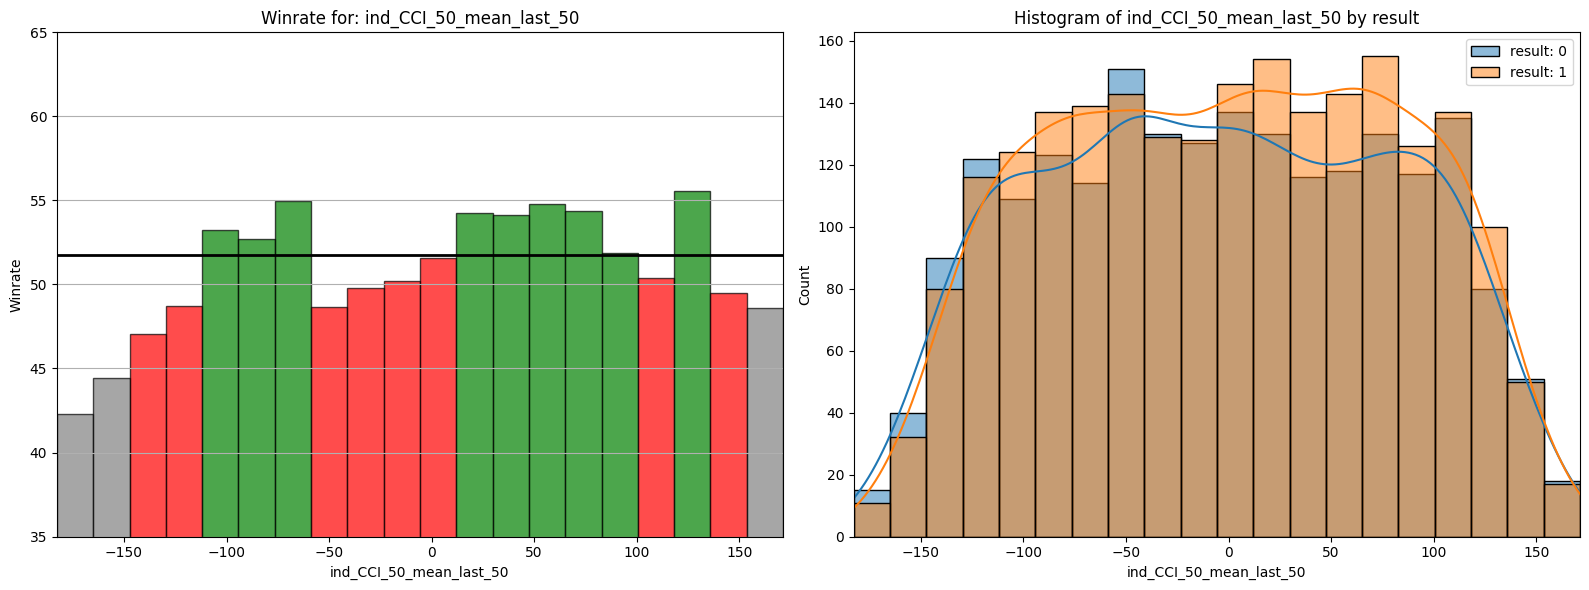

P-value of ind_CCI_50_mean_last_50: 0.11818663677764113
Beta of ind_CCI_50_mean_last_50: positive
P-value of ind_CCI_50_mean_last_50 squared: 0.13887222479641512
Beta of ind_CCI_50_mean_last_50 squared: negative
Log of ind_CCI_50_mean_last_50 has negative values
##########################################################################################################################################################################




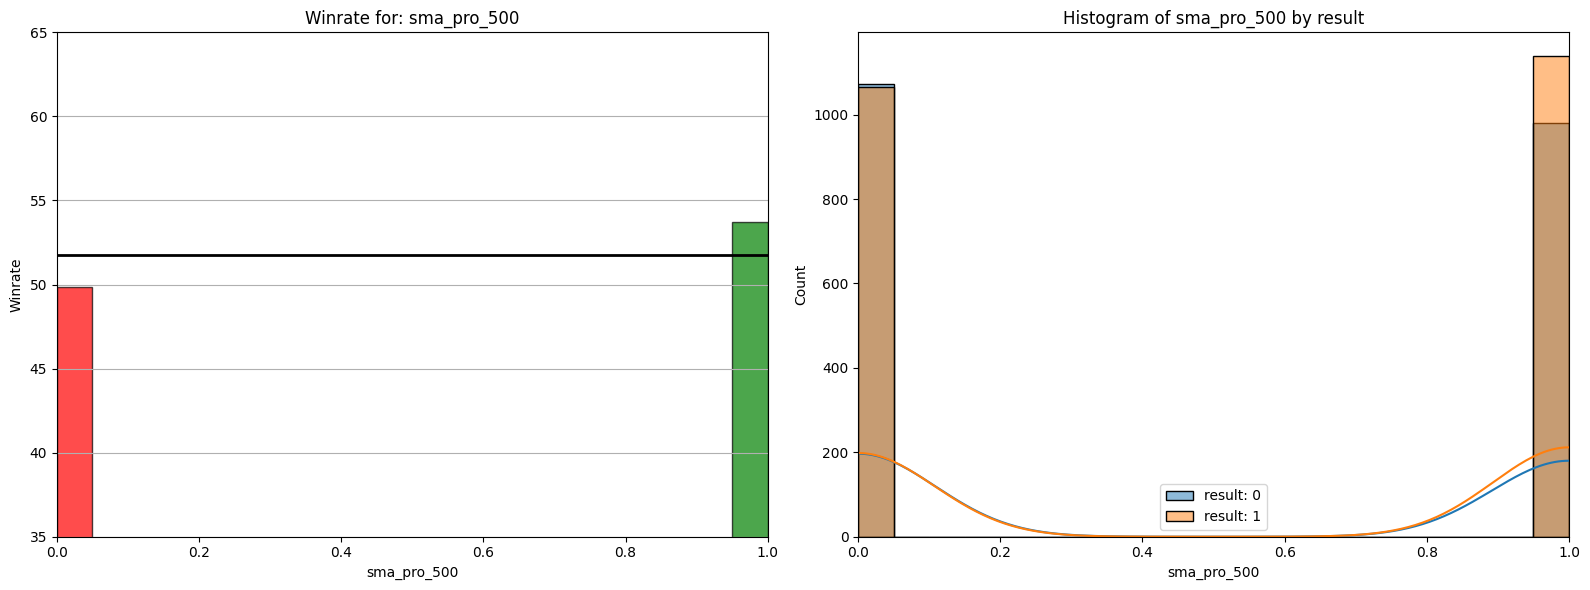

P-value of sma_pro_500: 0.012088155317074955
Beta of sma_pro_500: positive
P-value of sma_pro_500 squared: 0.012088155317074955
Beta of sma_pro_500 squared: positive
P-value of log of sma_pro_500: 0.012088155317074573
Beta of log of sma_pro_500: positive
##########################################################################################################################################################################




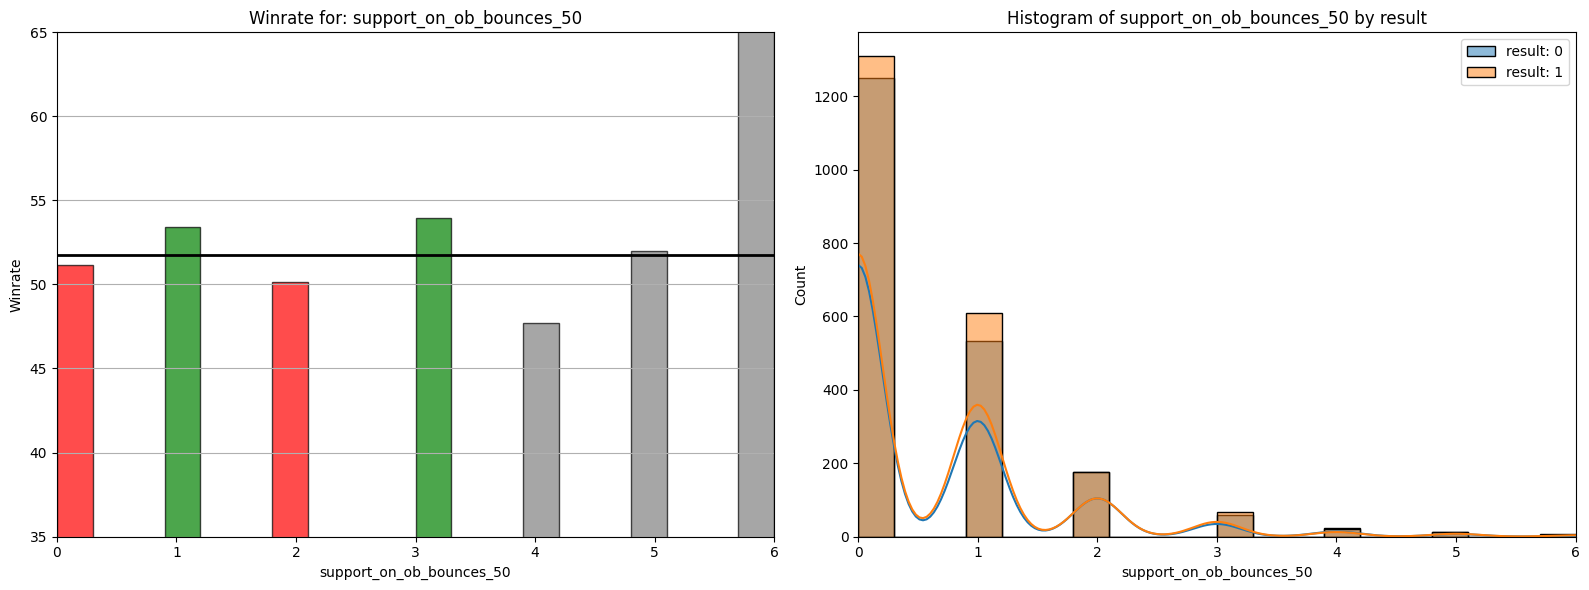

P-value of support_on_ob_bounces_50: 0.51684119974469
Beta of support_on_ob_bounces_50: positive
P-value of support_on_ob_bounces_50 squared: 0.5798289915887798
Beta of support_on_ob_bounces_50 squared: positive
P-value of log of support_on_ob_bounces_50: 0.32878591966720305
Beta of log of support_on_ob_bounces_50: positive
##########################################################################################################################################################################


Lots of observations with 0 value
Percentage of 0 in pa_crosses_with_ema500_to_entry_200_periods: 31.34%
Winrate for pa_crosses_with_ema500_to_entry_200_periods == 0: 51.57%
Winrate for pa_crosses_with_ema500_to_entry_200_periods != 0: 51.86%
Pvalue: 0.8604900259363393


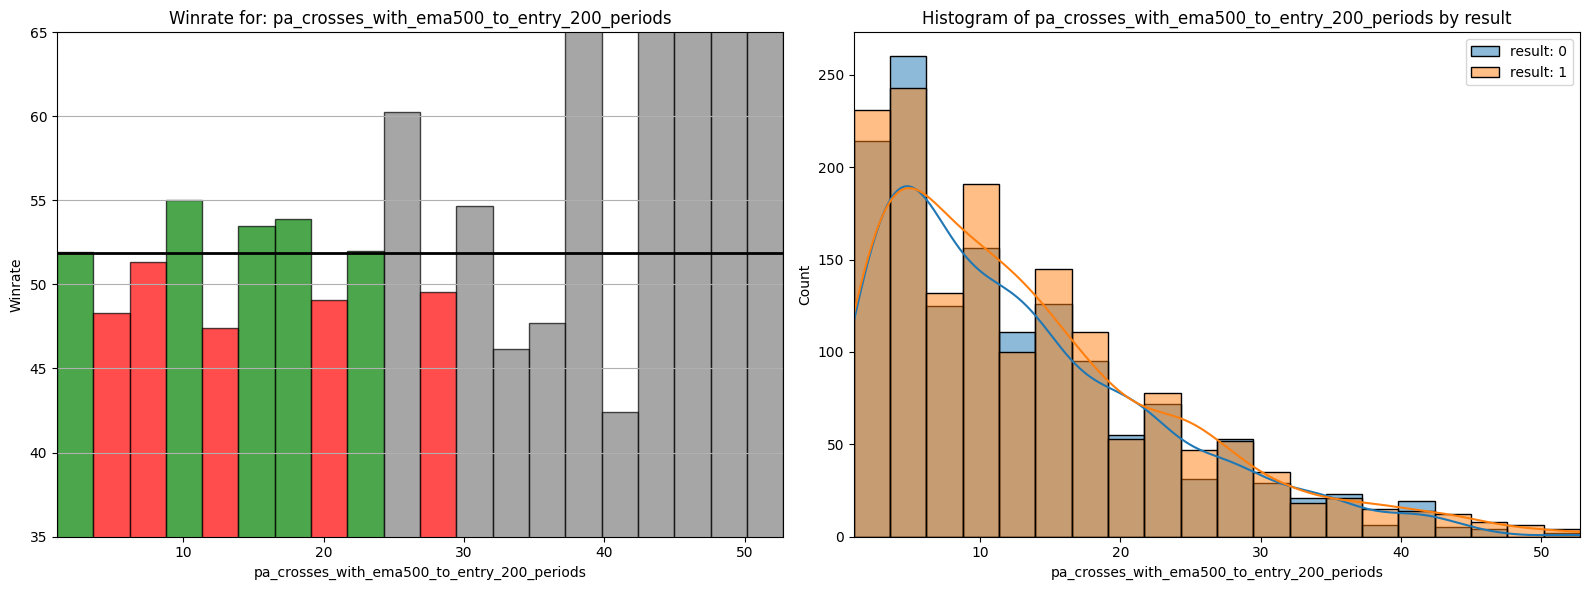

P-value of pa_crosses_with_ema500_to_entry_200_periods: 0.1357098624029908
Beta of pa_crosses_with_ema500_to_entry_200_periods: positive
P-value of pa_crosses_with_ema500_to_entry_200_periods squared: 0.07846136685073149
Beta of pa_crosses_with_ema500_to_entry_200_periods squared: positive
P-value of log of pa_crosses_with_ema500_to_entry_200_periods: 0.34953782572490577
Beta of log of pa_crosses_with_ema500_to_entry_200_periods: positive
##########################################################################################################################################################################




In [ ]:
final_results = pd.read_excel('wyniki_long_ob_5m_2018_2023_test.xlsx')
final_results.reset_index(drop=True, inplace=True)
# We are filtering out columns by previously set categories
pa_columns = [col for col in final_results.columns if col.startswith('pa')]
ind_columns = [col for col in final_results.columns if col.startswith('ind')]
support_columns = [col for col in final_results.columns if col.startswith('support')]
reglin_columns = [col for col in final_results.columns if col.startswith('reglin')]
entry_exit_columns = [col for col in final_results.columns if col.startswith(('entry', 'exit', 'result'))]
other_columns = [col for col in final_results.columns if col not in pa_columns and col not in ind_columns and col not in support_columns and col not in reglin_columns and col not in entry_exit_columns]
# R (relation of take profit size to stoploss size) and columns we want to visualize are set manually
R = 1
R = 'result_'+str(R)+'R'
columns_to_visualize = ['ind_CCI_50_mean_last_50', 'sma_pro_500', 'support_on_ob_bounces_50', 'pa_crosses_with_ema500_to_entry_200_periods']
for indicator in columns_to_visualize:

    #SECTION - data visualization
    def analyze_indicator(wyniki, indicator, R):
        # I have calculated quantiles for our indicator, to cut off outliers
        max_value = wyniki[indicator].quantile(0.999)
        min_value = wyniki[indicator].quantile(0.001)

        # I checked if we have a lot of 0 values, if we do, we are checking if it has any impact on winrate
        # It has to be done that way, as in some variables 0 means that variable might not be calculable, so relationship with winrate might be different
        if wyniki[indicator].value_counts().get(0, 0) > 0.3 * len(wyniki) and max_value > 10:
            min_value = wyniki[indicator].replace(0, np.nan).min()
            wyniki_sorted = wyniki[wyniki[indicator] != 0].copy()
            print("Lots of observations with 0 value")
            print(f"Percentage of 0 in {indicator}: {wyniki[indicator].value_counts().get(0, 0) / len(wyniki) * 100:.2f}%")
            print(f"Winrate for {indicator} == 0: {wyniki[wyniki[indicator] == 0][R].value_counts()[1] / len(wyniki[wyniki[indicator] == 0]) * 100:.2f}%")
            print(f"Winrate for {indicator} != 0: {wyniki[wyniki[indicator] != 0][R].value_counts()[1] / len(wyniki[wyniki[indicator] != 0]) * 100:.2f}%")
            pvalue = stats.ttest_ind(wyniki[wyniki[indicator] == 0][R], wyniki[wyniki[indicator] != 0][R], equal_var=False)[1]
            print(f"Pvalue: {pvalue}")
        else:
            wyniki_sorted = wyniki.copy()

        # I defined number of bins and range of values for each indicator
        number_of_bins = 20
        wyniki_sorted[indicator] = wyniki_sorted[indicator].clip(lower=min_value, upper=max_value)

        # If all values are integers then we want to visualize them as with number of bins equal to number of unique values
        # But there are more then 20 unique values, I have written code to lower amount of bins, for it to be readable
        all_integers = np.isclose(wyniki_sorted[indicator], wyniki_sorted[indicator].astype(int)).all()
        if all_integers and len(wyniki) < 200:
            max_value = int(max_value)
            unique_values = wyniki_sorted[indicator].unique()
            number_of_bins = len(unique_values)
            if number_of_bins > 20:
                for structure_index in range(2, number_of_bins):
                    if number_of_bins % structure_index == 0:
                        number_of_bins = int(number_of_bins / structure_index)
                        break
        
        # Charts are created for each indicator, showcasing winrate, histogram of indicator by result
        # I have also changed colors of bars, to showcase if winrate is higher or lower than average winrate, or number of observations is too low for it to be relevant
        bins = np.linspace(min_value, max_value, number_of_bins + 1)
        total_counts, _ = np.histogram(wyniki_sorted[indicator], bins=bins)
        ones_counts, _ = np.histogram(wyniki_sorted[wyniki_sorted[R] == 1][indicator], bins=bins)
        percentage_ones = np.divide(ones_counts, total_counts, out=np.zeros_like(ones_counts, dtype=float), where=total_counts != 0) * 100
        bin_centers = (bins[:-1] + bins[1:]) / 2
        win_rate = wyniki_sorted[R].value_counts()[1] / len(wyniki_sorted) * 100
        colors = ['green' if percent > win_rate and count > 100 else 'grey' if count < 100 else 'red' for count, percent in zip(total_counts, percentage_ones)]

        # Charts are visualized using matplotlib and seaborn in such way, that for each indicator we have two charts next to each other for easier comparison
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        axs[0].bar(bin_centers, percentage_ones, width=(max_value - min_value) / number_of_bins, align='center', alpha=0.7, color=colors, edgecolor='black')
        axs[0].set_title(f"Winrate for: {indicator}")
        axs[0].set_xlabel(indicator)
        axs[0].set_ylabel('Winrate')
        axs[0].set_ylim(35, 65)
        axs[0].grid(axis='y')

        # I have also added a line that showcases average winrate
        axs[0].axhline(y=win_rate, color='black', linestyle='-', linewidth=2)
        axs[0].set_xlim(min_value, max_value)

        binwidth = (max_value - min_value) / number_of_bins
        for result in (0, 1):
            sns.histplot(wyniki_sorted[wyniki_sorted[R] == result][indicator], kde=True, label=f'result: {result}', binwidth=binwidth, binrange=(min_value, max_value), ax=axs[1])

        axs[1].set_title(f"Histogram of {indicator} by result")
        axs[1].legend()
        axs[1].set_xlim(min_value, max_value)

        plt.tight_layout()
        plt.show()

        # P-value and beta for each indicator have been calculated, as well as for squared and log of indicator for non linear relationships
        X = wyniki_sorted[indicator]
        y = wyniki_sorted[R]
        X = sm.add_constant(X)
        model = sm.Logit(y, X)
        result = model.fit(disp=False)
        print(f"P-value of {indicator}: {result.pvalues.iloc[1]}")
        print(f"Beta of {indicator}: {'positive' if result.params.iloc[1] > 0 else 'negative'}")

        X_2 = wyniki_sorted[indicator] ** 2
        X_2 = sm.add_constant(X_2)
        model = sm.Logit(y, X_2)
        result = model.fit(disp=False)
        print(f"P-value of {indicator} squared: {result.pvalues.iloc[1]}")
        print(f"Beta of {indicator} squared: {'positive' if result.params.iloc[1] > 0 else 'negative'}")

        if wyniki_sorted[indicator].min() >= 0:
            wyniki_sorted[indicator] = wyniki_sorted[indicator].replace(0, 0.0000001)
            X_log = np.log(wyniki_sorted[indicator])
            X_log = sm.add_constant(X_log)
            model = sm.Logit(y, X_log)
            result = model.fit(disp=False)
            print(f"P-value of log of {indicator}: {result.pvalues.iloc[1]}")
            print(f"Beta of log of {indicator}: {'positive' if result.params.iloc[1] > 0 else 'negative'}")
        else:
            print(f"Log of {indicator} has negative values")

        print("#" * 170)
        print("\n")

    analyze_indicator(final_results, indicator, R)
    #!SECTION

# Visualization of interactions between variables


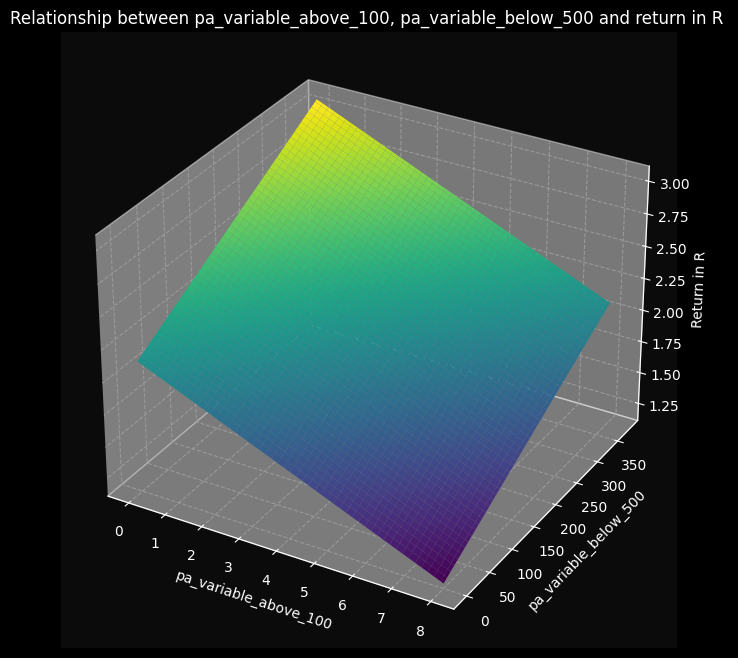

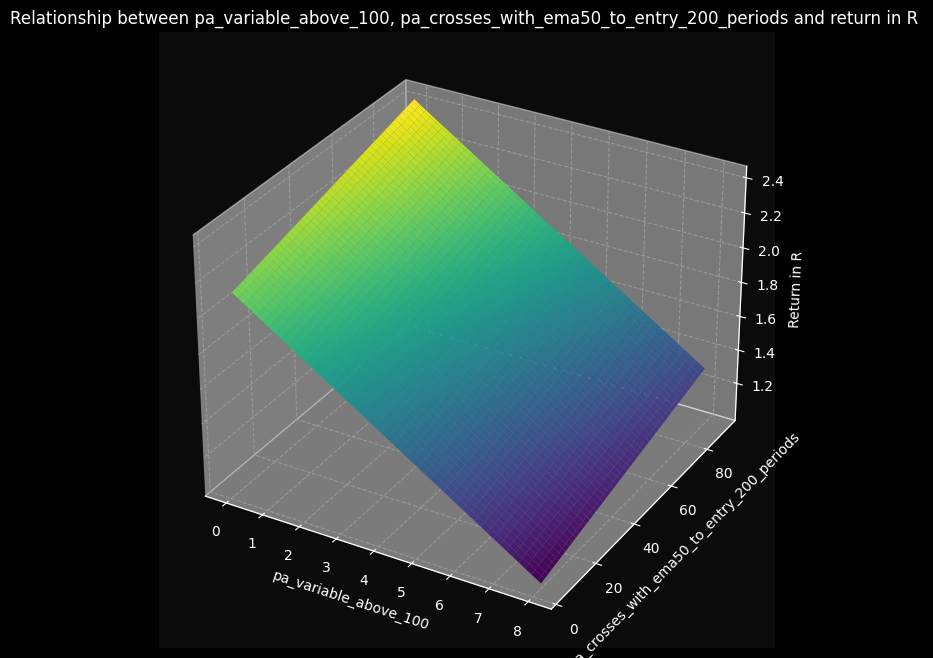

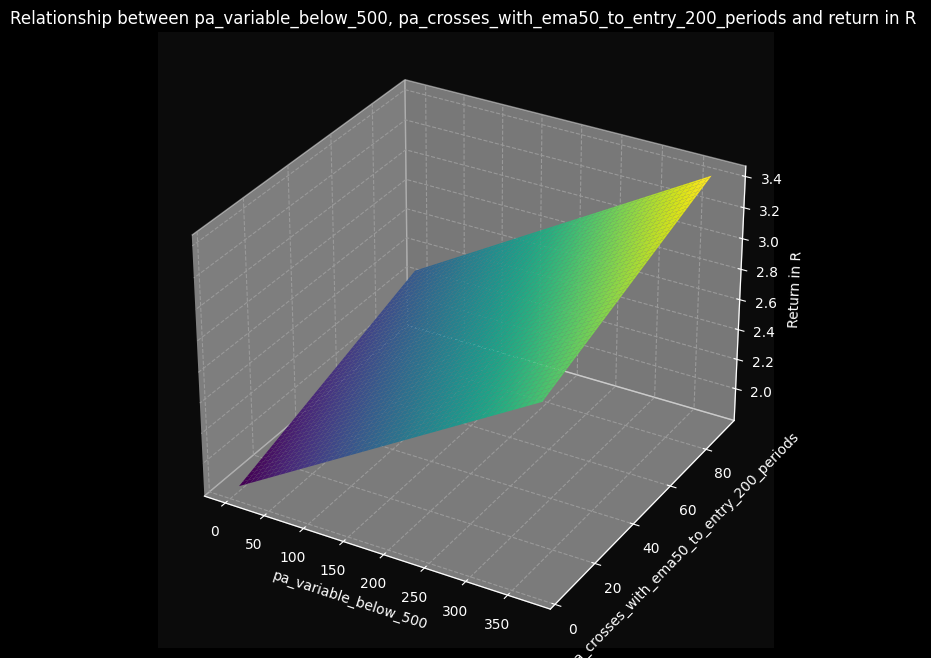

In [28]:
df = pd.read_excel('wyniki_long_ob_5m_2018_2023_test.xlsx')
import itertools

# We can select variables that we suspect of having a relationship with the target variable
selected_vars = ['pa_variable_above_100','pa_variable_below_500','pa_crosses_with_ema50_to_entry_200_periods']

# Combinations of all of them are created using itertools
combinations = list(itertools.combinations(selected_vars, 2))

# We loop visualizations for each combination
for combination in combinations:
    var1, var2 = combination
    # Model is fitted using statsmodels
    X = df[[var1, var2]]
    X = sm.add_constant(X)
    y = df['result_R']
    model = sm.OLS(y, X)
    result = model.fit()
    
    # Data is prepared for 3D visualization
    var1_values = np.linspace(X[var1].min(), X[var1].max(), 100)
    var2_values = np.linspace(X[var2].min(), X[var2].max(), 100)
    var1_grid, var2_grid = np.meshgrid(var1_values, var2_values)
    visualize_data = pd.DataFrame({'const': np.ones(var1_grid.size), var1: var1_grid.flatten(), var2: var2_grid.flatten()})
    visualize_data['Prob_A'] = result.predict(visualize_data)
    
    # Charts are created
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(var1_grid, var2_grid, visualize_data['Prob_A'].values.reshape(var1_grid.shape), cmap='viridis')
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)
    ax.set_zlabel('Return in R')
    ax.set_title(f'Relationship between {var1}, {var2} and return in R ')
    plt.show()

To evaluate the effectiveness of our strategies, we will primarily rely on the profit chart rather than standard statistical measures such as accuracy, precision, or mean squared error. This is because the profit chart directly addresses the core problem our model aims to solve—maximizing returns in a real-world trading environment.

Additionally, the data we are working with presents significant challenges due to shifting distributions over time. As research indicates, traditional measures like R^2
may fail to capture the true usefulness of a model in such dynamic conditions. Instead, focusing on performance-based metrics that reflect real market outcomes ensures a more practical and reliable evaluation of our approach.

One key consideration is that autocorrelation may arise in these models, and constructing ACF and PACF charts can be very useful in identifying it. However, testing for autocorrelation is quite challenging due to overlapping trade times, which can lead to false correlations. Specifically, if one trade has not yet closed when another trade is opened, their results will inherently be correlated, skewing the analysis. Because of this, this element is skipped in the current project, but should be considered in future updates.

# Backtest of the strategy



C:\Users\Maciek\AppData\Local\Temp\ipykernel_8968\3032910599.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'risk'] = interp_high[i]
C:\Users\Maciek\AppData\Local\Temp\ipykernel_8968\3032910599.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.0183283582089553' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'result'] = df.at[i-1, 'result'] * (1 + R_per_trade * df.at[i, 'risk'] - df.at[i, 'risk'] * spread / df.at[i, 'tp_size'] - df.at[i, 'risk'] * slippage / df.at[i, 'tp_size'])


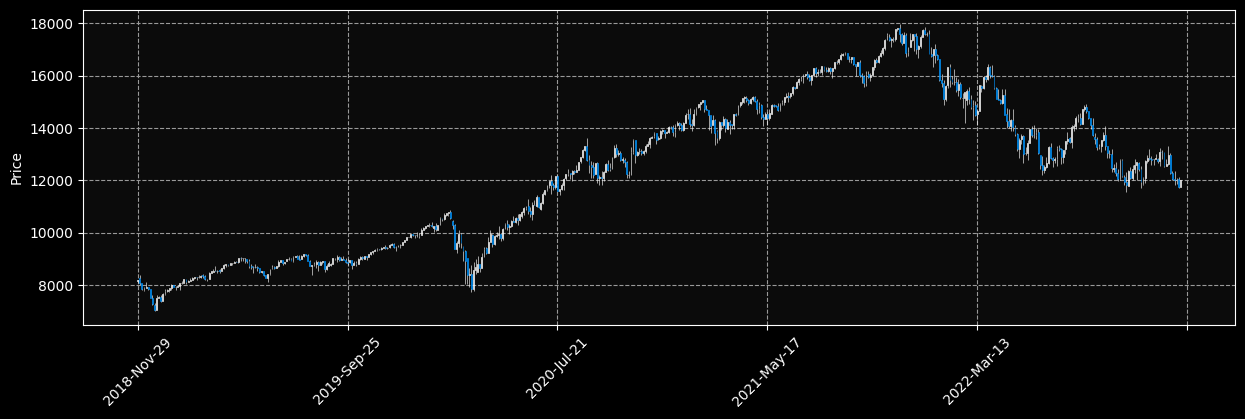

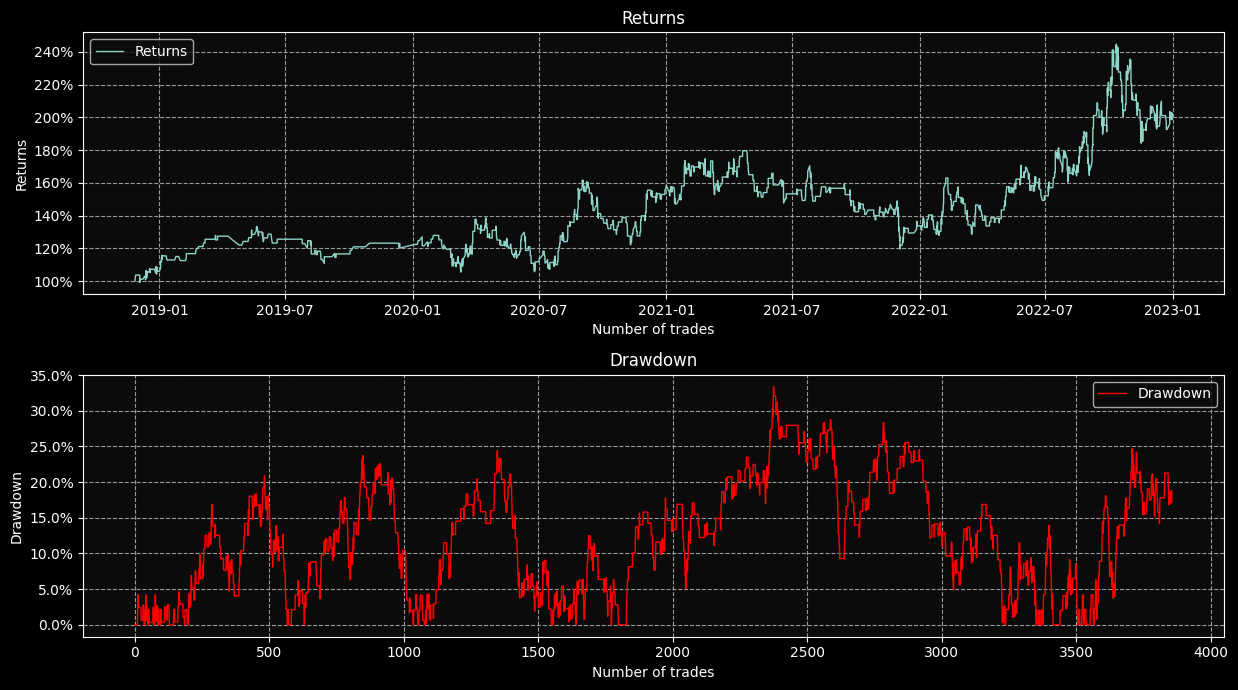

Metric                    Value
------------------------  -------------------------
Winrate overall           54.8%
Buy threshold             65.00%
R per trade               1.0
Winrate to break even     50%
Return                    202%
Max drawdown              33%
Paid fees                 112.43%
Number of trades overall  1062
% of traded setups        28%
Return to max drawdown    3.1
Average transaction time  0 days 00:52:08.135593220
                           Logit Regression Results                           
Dep. Variable:              result_1R   No. Observations:                  400
Model:                          Logit   Df Residuals:                      353
Method:                           MLE   Df Model:                           46
Date:                Sun, 14 Jul 2024   Pseudo R-squ.:                 0.07866
Time:                        20:58:28   Log-Likelihood:                -253.41
converged:                       True   LL-Null:                       -275.05


In [ ]:
df = pd.read_excel('wyniki_long_ob_5m_2018_2023_test.xlsx', engine='openpyxl')
df.sort_values(by='entry_time', inplace=True)
df.reset_index(drop=True, inplace=True)

# R has to be definied manually, depending on what we want to calculate
R = 1
take_profit = str(R) + 'R'

exit_time = f'exit_time_{take_profit}'
# creating variable checking if previous trade closed
df['already_in_trade'] = 0
for i in range(1, len(df)):
    df.at[i,'already_in_trade'] = 1 if any(df.loc[:i-1,exit_time] > df.at[i,'entry_time']) else 0

time_column = ['entry_time', exit_time]

ind_columns = [col for col in df.columns if col.startswith('ind')]
pa_columns = [col for col in df.columns if col.startswith('pa')]
support_columns = [col for col in df.columns if col.startswith('support')]
vol_columns = [col for col in df.columns if col.startswith('vol')]
reglin_columns = [col for col in df.columns if col.startswith('reglin')]
entry_exit_columns = [col for col in df.columns if col.startswith(('entry', 'exit', 'result'))]
mean_columns = [col for col in df.columns if 'mean' in col]
other_columns = [col for col in df.columns if col not in pa_columns and col not in ind_columns and col not in support_columns and col not in vol_columns and col not in reglin_columns and col not in entry_exit_columns]

columns_to_test = support_columns + pa_columns

# Some variables have to be set manually
whole_model = False
# Lookback period is variables defining how many candles we are looking back to calculate probabilities
lookback_period = 400
# We can use scalable position sizing depending on probability of trade
min_risk, max_risk = 0.02, 0.02
R_per_trade = float(R)
# wr_to_break_even is variable showcasing how much winrate we need to break even
wr_to_break_even = 1/(1+R_per_trade)
# buy_threshold is variable showcasing how much probability we need to buy
buy_threshold = wr_to_break_even*1.3
# max_risk_at is variable showcasing how much probability we need to have max risk
max_risk_at = buy_threshold*1.25
# spread and slippage are variables showcasing how much we pay for each trade
spread = 1.2
slippage = 0.2
model_type = 'logit'
# Variables for xgb and random forest
max_depth = 6
n_estimators = 100
min_child_weight = 20
learning_rate = 0.1
min_samples_split = 2

#SECTION - calculating strategy results
def strategy_results(df, columns_to_test, time_column, exit_time, take_profit, lookback_period,whole_model, buy_threshold, max_risk_at, min_risk, max_risk, R_per_trade, spread,slippage, wr_to_break_even, model_type, max_depth, n_estimators, min_child_weight, learning_rate, min_samples_split):
    # Prepare data
    X = df[columns_to_test].copy()
    X_times = df.loc[:, time_column].copy()
    X = pd.concat([X_times, X], axis=1)
    result_for_y = f'result_{take_profit}'
    y = df.loc[:, result_for_y].copy()
    new_columns = [col if i < 2 else f'{i-1}_{col}' for i, col in enumerate(X.columns)]
    X.columns = new_columns

    X = sm.add_constant(X)
    df['Predicted_Probabilities'] = None
    df['risk'] = 0

    # Calculate probabilities
    for i in range(lookback_period, len(X)):
        X_for_model = X.loc[:i-1].copy()
        y_for_model = y.loc[:i-1].copy()
        X_to_predict = X.loc[i:i].copy()

        for z in range(i-lookback_period, i):
            if X_for_model.at[z, exit_time] > X_to_predict.at[i, 'entry_time']:
                X_for_model.drop(z, inplace=True)
                y_for_model.drop(z, inplace=True)
        X_for_model.reset_index(drop=True, inplace=True)
        y_for_model.reset_index(drop=True, inplace=True)
        X_for_model.drop(columns=time_column, inplace=True)

        # We can use whole model or only last lookback_period candles
        if whole_model:
            X_model = X_for_model
            y_model = y_for_model
        else:
            X_model = X_for_model.iloc[-lookback_period:].copy()
            y_model = y_for_model.iloc[-lookback_period:].copy()


        X_to_predict.drop(columns=time_column, inplace=True)

        # Model selection
        if model_type == 'logit':
            model = sm.Logit(y_model, X_model)
            result = model.fit(disp=0)
            predicted_probabilities = result.predict(X_to_predict).values[0]

        elif model_type == 'random_forest':
            model = RandomForestClassifier(n_estimators=100)
            model.fit(X_model, y_model)
            predicted_probabilities = model.predict_proba(X_to_predict)[:, 1][0]
        
        elif model_type == 'xgboost':
            model = xgb.XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, min_child_weight=min_child_weight)
            model.fit(X_model, y_model)
            predicted_probabilities = model.predict_proba(X_to_predict)[:, 1][0]
        
        df.at[i, 'Predicted_Probabilities'] = predicted_probabilities

    # Calculate risk by scaling position size based on probability
    interp_high = np.interp(df['Predicted_Probabilities'], [buy_threshold, max_risk_at], [min_risk, max_risk])
    for i in range(lookback_period, len(df)):
        if df.at[i, 'Predicted_Probabilities'] > buy_threshold:
            df.at[i, 'risk'] = interp_high[i]
        else:
            df.at[i, 'risk'] = 0

    df['result'] = 1
    wins_overall = 0
    loses_overall = 0
    max_result = 1
    drawdowns = []
    transaction_times = []
    paid_fees = 0.0

    # We are calculating results of the strategy including transaction costs
    for i in range(lookback_period, len(df)):
        if df.at[i, 'Predicted_Probabilities'] >= buy_threshold and y[i] == 1:
            df.at[i, 'result'] = df.at[i-1, 'result'] * (1 + R_per_trade * df.at[i, 'risk'] - df.at[i, 'risk'] * spread / df.at[i, 'tp_size'] - df.at[i, 'risk'] * slippage / df.at[i, 'tp_size'])
            wins_overall += 1
            transaction_time = df.at[i, exit_time] - df.at[i, 'entry_time']
            transaction_times.append(transaction_time)
            paid_fees += df.at[i, 'risk'] * spread / df.at[i, 'tp_size'] + df.at[i, 'risk'] * slippage / df.at[i, 'tp_size']
        elif df.at[i, 'Predicted_Probabilities'] >= buy_threshold and y[i] == 0:
            df.at[i, 'result'] = df.at[i-1, 'result'] * (1 - df.at[i, 'risk'] - df.at[i, 'risk'] * spread / df.at[i, 'tp_size'] - df.at[i, 'risk'] * slippage / df.at[i, 'tp_size'])
            loses_overall += 1
            transaction_time = df.at[i, exit_time] - df.at[i, 'entry_time']
            transaction_times.append(transaction_time)
            paid_fees += df.at[i, 'risk'] * spread / df.at[i, 'tp_size'] + df.at[i, 'risk'] * slippage / df.at[i, 'tp_size']
        else:
            df.at[i, 'result'] = df.at[i-1, 'result']

        max_result = max(max_result, df.at[i, 'result'])
        drawdown = (max_result - df.at[i, 'result']) / max_result
        drawdowns.append(drawdown)

    # We are plotting only period of time where we have trades
    first_trade = df['entry_time'].iloc[lookback_period]
    last_trade = df['entry_time'].iloc[-1]

    file_path = os.path.join('..', 'data', 'nasdaq', '20082024.txt')
    df_to_plot = pd.read_csv(file_path, names=['timestamp', 'open', 'high', 'low', 'close', 'Volume'], header=None)
    df_to_plot['timestamp'] = pd.to_datetime(df_to_plot['timestamp'])
    df_to_plot.set_index('timestamp', inplace=True)
    df_to_plot = df_to_plot.resample('3D').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'})
    df_to_plot.reset_index(inplace=True)
    df_to_plot = df_to_plot.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'})
    df_candlestick = df_to_plot.loc[(df_to_plot['timestamp'] >= first_trade) & (df_to_plot['timestamp'] <= last_trade)]
    df_candlestick.set_index('timestamp', inplace=True)
    mpf.plot(df_candlestick, type='candle', figsize=(16, 4.5), style='nightclouds')

    df_plot = df.set_index('entry_time')
    df_plot = df_plot.iloc[lookback_period:]['result']

    plt.figure(figsize=(12.5, 7))
    plt.subplot(2, 1, 1)
    plt.plot(df_plot, label='Returns')
    plt.title('Returns')
    plt.xlabel('Number of trades')
    plt.ylabel('Returns')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(drawdowns, label='Drawdown', color='red')
    plt.title('Drawdown')
    plt.xlabel('Number of trades')
    plt.ylabel('Drawdown')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.legend()

    plt.tight_layout()
    plt.show()
    max_drawdown = max(drawdowns) * 100

    # Using tabulate function, we are showcasing results of the strategy
    if wins_overall + loses_overall > 0:
        winrate_ogolnie = wins_overall / (wins_overall + loses_overall)
        percentage_return = df['result'].iloc[-1] * 100
        print(tabulate([
            ["Winrate overall", f"{winrate_ogolnie*100:.1f}%"],
            ["Buy threshold", f"{buy_threshold*100:.2f}%"],
            ["R per trade", f"{R_per_trade:.1f}"],
            ["Winrate to break even", f"{wr_to_break_even*100:.0f}%"],
            ["Return", f"{percentage_return:.0f}%"],
            ["Max drawdown", f"{max(drawdowns)*100:.0f}%"],
            ["Paid fees", f"{paid_fees*100:.2f}%"],
            ["Number of trades overall", wins_overall + loses_overall],
            ["% of traded setups", f"{(wins_overall + loses_overall)*100/(len(df)-lookback_period):.0f}%"],
            ["Return to max drawdown", f"{(percentage_return-100)/max_drawdown:.1f}"],
            ["Average transaction time", np.mean(transaction_times)]
        ], headers=["Metric", "Value"]))
    else:
        print("No trades")

    print(result.summary())

    difference_in_days = (df['entry_time'].iloc[-1] - df['entry_time'].iloc[lookback_period]).days
    difference_in_months = difference_in_days / 30.4375  # average number of days in a month
    number_of_trades_overall_per_day = (wins_overall + loses_overall) / difference_in_days
    multiplier = 365 / 252  # 252 trading days in a year

    print(tabulate([
        ["First trade", first_trade],
        ["Last trade", last_trade],
        ["Period of trading", f"{difference_in_months:.2f} months"],
        ["Number of trades overall per day", f"{number_of_trades_overall_per_day * multiplier:.2f}"]
    ]))

strategy_results(df, columns_to_test, time_column, exit_time, take_profit, lookback_period,whole_model, buy_threshold, max_risk_at, min_risk, max_risk, R_per_trade, spread, slippage, wr_to_break_even, model_type, max_depth, n_estimators, min_child_weight, learning_rate, min_samples_split)
#!SECTION

The model demonstrates strong predictive power, outperforming the baseline strategy by 5%, which is a notable achievement in quantitative finance given its complexity. Eight of the variables are statistically significant at a 90% confidence level. The main advantage of this model lies in its simplicity and interpretability. The next step is to test other, more complex models.

# Random Forest Model

C:\Users\Maciek\AppData\Local\Temp\ipykernel_4532\2396218626.py:115: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'risk'] = interp_high[i]
C:\Users\Maciek\AppData\Local\Temp\ipykernel_4532\2396218626.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9783529411764705' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'result'] = df.at[i-1, 'result'] * (1 - df.at[i, 'risk'] - df.at[i, 'risk'] * spread / df.at[i, 'tp_size'] - df.at[i, 'risk'] * slippage / df.at[i, 'tp_size'])


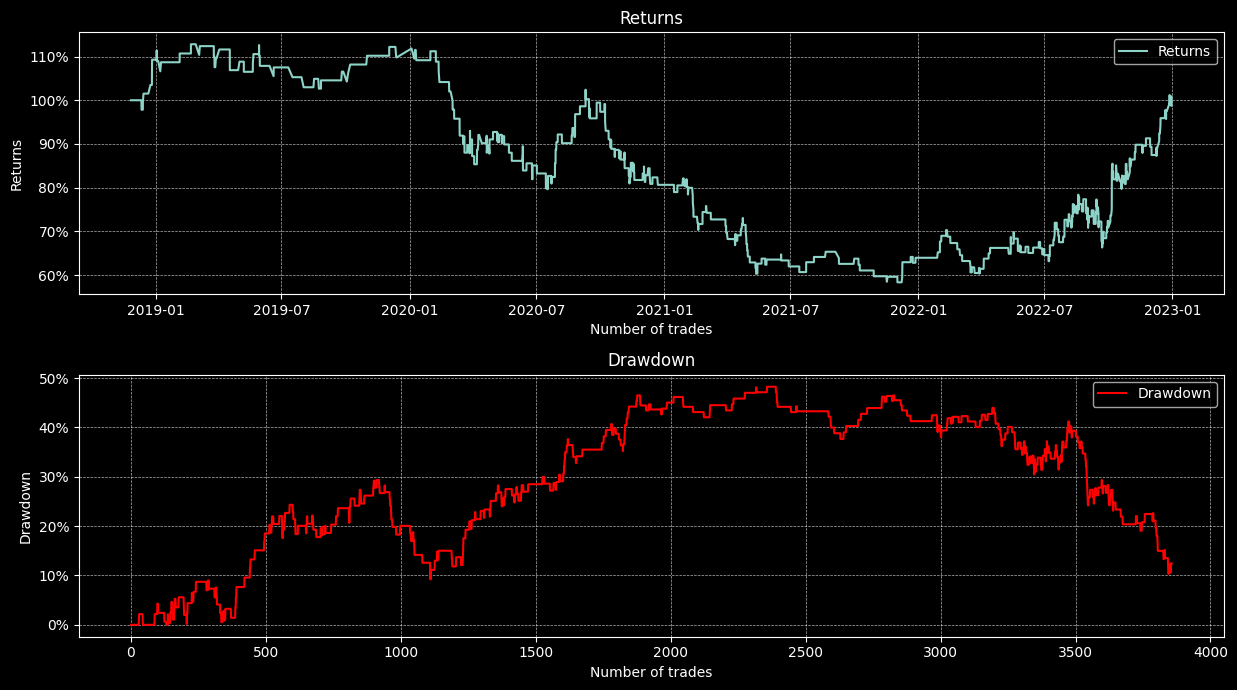

Metric                    Value
------------------------  -------------------------
Winrate overall           53.3%
Buy threshold             65.00%
R per trade               1.0
Winrate to break even     50%
Return                    99%
Max drawdown              48%
Paid fees                 46.88%
Number of trades overall  493
% of traded setups        13%
Return to max drawdown    -0.0
Average transaction time  0 days 00:48:20.446247464
--------------------------------  -------------------
First trade                       2018-11-26 17:00:00
Last trade                        2022-12-30 17:40:00
Period of trading                 49.12 months
Number of trades overall per day  0.48
--------------------------------  -------------------


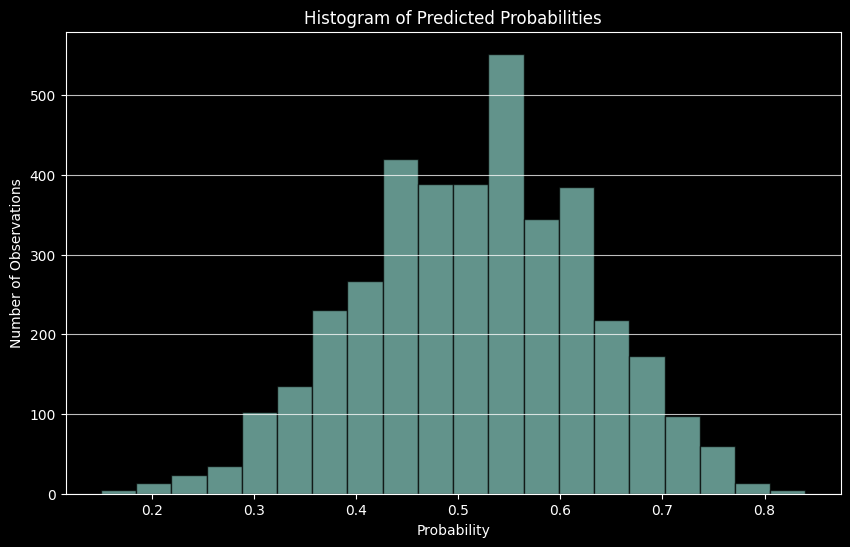

In [ ]:
whole_model = False
lookback_period = 400
min_risk, max_risk = 0.02, 0.02
R_per_trade = float(R)
wr_to_break_even = 1/(1+R_per_trade)
buy_threshold = wr_to_break_even*1.3
max_risk_at = buy_threshold*1.25
spread = 1.2
slippage = 0.2
model_type = 'random_forest'

n_estimators = 100
max_depth = None
min_samples_split = 2

strategy_results(df, columns_to_test, time_column, exit_time, take_profit, lookback_period,whole_model, buy_threshold, max_risk_at, min_risk, max_risk, R_per_trade, spread, slippage, wr_to_break_even, model_type, max_depth, n_estimators, min_child_weight, learning_rate, min_samples_split)

Our random forest model appears to have some predictive power, but there is room for improvement. To enhance its performance, We will adjust our approach by increasing the amount of data used in the rolling window for model training, as this may be necessary for capturing non-linear relationships without being concerned about noise in the data. Additionally, we will set the min_samples_split parameter to 50 to reduce overfitting, lower the number of estimators for computational efficiency, and then recalculate the model.

C:\Users\Maciek\AppData\Local\Temp\ipykernel_4532\3429221828.py:115: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'risk'] = interp_high[i]
C:\Users\Maciek\AppData\Local\Temp\ipykernel_4532\3429221828.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9781935483870967' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'result'] = df.at[i-1, 'result'] * (1 - df.at[i, 'risk'] - df.at[i, 'risk'] * spread / df.at[i, 'tp_size'] - df.at[i, 'risk'] * slippage / df.at[i, 'tp_size'])


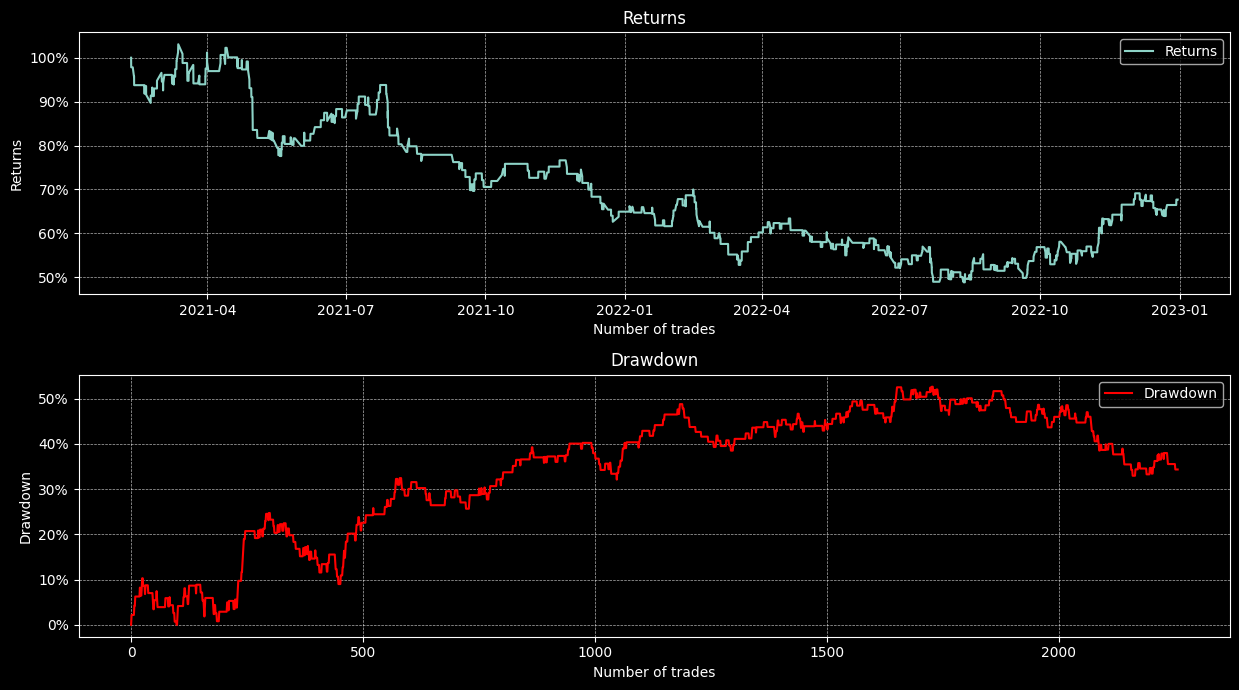

Metric                    Value
------------------------  -------------------------
Winrate overall           50.8%
Buy threshold             60.00%
R per trade               1.0
Winrate to break even     50%
Return                    68%
Max drawdown              53%
Paid fees                 44.24%
Number of trades overall  437
% of traded setups        19%
Return to max drawdown    -0.6
Average transaction time  0 days 01:05:10.572082379
--------------------------------  -------------------
First trade                       2021-02-09 20:10:00
Last trade                        2022-12-30 17:40:00
Period of trading                 22.60 months
Number of trades overall per day  0.92
--------------------------------  -------------------


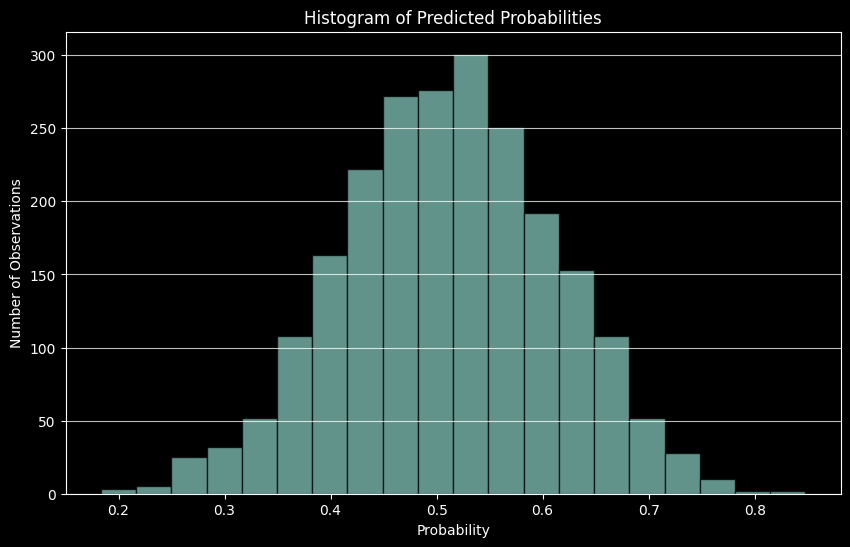

----------------  -------------
Model type        random_forest
Max depth
N estimators      10
Min child weight  50
Buy threshold     60.00%
----------------  -------------


In [ ]:
whole_model = False
lookback_period = 2000
min_risk, max_risk = 0.02, 0.02
R_per_trade = float(R)
wr_to_break_even = 1/(1+R_per_trade)
buy_threshold = wr_to_break_even*1.2
max_risk_at = buy_threshold*1.25
spread = 1.2
slippage = 0.2
model_type = 'random_forest'

n_estimators = 10
max_depth = None
min_samples_split = 50

def strategy_results(df, columns_to_test, time_column, exit_time, take_profit, lookback_period,whole_model, buy_threshold, max_risk_at, min_risk, max_risk, R_per_trade, spread,slippage, wr_to_break_even, model_type, max_depth, n_estimators, min_child_weight, learning_rate, min_samples_split):
    # Prepare data
    X = df[columns_to_test].copy()
    X_times = df.loc[:, time_column].copy()
    X = pd.concat([X_times, X], axis=1)
    result_for_y = f'result_{take_profit}'
    y = df.loc[:, result_for_y].copy()
    new_columns = [col if i < 2 else f'{i-1}_{col}' for i, col in enumerate(X.columns)]
    X.columns = new_columns

    X = sm.add_constant(X)
    df['Predicted_Probabilities'] = None
    df['risk'] = 0

    # Calculate probabilities
    for i in range(lookback_period, len(X)):
        X_for_model = X.loc[:i-1].copy()
        y_for_model = y.loc[:i-1].copy()
        X_to_predict = X.loc[i:i].copy()

        for z in range(i-lookback_period, i):
            if X_for_model.at[z, exit_time] > X_to_predict.at[i, 'entry_time']:
                X_for_model.drop(z, inplace=True)
                y_for_model.drop(z, inplace=True)
        X_for_model.reset_index(drop=True, inplace=True)
        y_for_model.reset_index(drop=True, inplace=True)
        X_for_model.drop(columns=time_column, inplace=True)

        # We can use whole model or only last lookback_period candles
        if whole_model:
            X_model = X_for_model
            y_model = y_for_model
        else:
            X_model = X_for_model.iloc[-lookback_period:].copy()
            y_model = y_for_model.iloc[-lookback_period:].copy()

        X_to_predict.drop(columns=time_column, inplace=True)

        # Model selection
        if model_type == 'logit':
            model = sm.Logit(y_model, X_model)
            result = model.fit(disp=0)
            predicted_probabilities = result.predict(X_to_predict).values[0]

        elif model_type == 'random_forest':
            model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
            model.fit(X_model, y_model)
            predicted_probabilities = model.predict_proba(X_to_predict)[:, 1][0]
        
        elif model_type == 'xgboost':
            model = xgb.XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, min_child_weight=min_child_weight)
            model.fit(X_model, y_model)
            predicted_probabilities = model.predict_proba(X_to_predict)[:, 1][0]
        
        df.at[i, 'Predicted_Probabilities'] = predicted_probabilities

    # Calculate risk by scaling position size based on probability
    interp_high = np.interp(df['Predicted_Probabilities'], [buy_threshold, max_risk_at], [min_risk, max_risk])
    for i in range(lookback_period, len(df)):
        if df.at[i, 'Predicted_Probabilities'] > buy_threshold:
            df.at[i, 'risk'] = interp_high[i]
        else:
            df.at[i, 'risk'] = 0

    df['result'] = 1
    wins_overall = 0
    loses_overall = 0
    max_result = 1
    drawdowns = []
    transaction_times = []
    paid_fees = 0.0

    # We are calculating results of the strategy including transaction costs
    for i in range(lookback_period, len(df)):
        if df.at[i, 'Predicted_Probabilities'] >= buy_threshold and y[i] == 1:
            df.at[i, 'result'] = df.at[i-1, 'result'] * (1 + R_per_trade * df.at[i, 'risk'] - df.at[i, 'risk'] * spread / df.at[i, 'tp_size'] - df.at[i, 'risk'] * slippage / df.at[i, 'tp_size'])
            wins_overall += 1
            transaction_time = df.at[i, exit_time] - df.at[i, 'entry_time']
            transaction_times.append(transaction_time)
            paid_fees += df.at[i, 'risk'] * spread / df.at[i, 'tp_size'] + df.at[i, 'risk'] * slippage / df.at[i, 'tp_size']
        elif df.at[i, 'Predicted_Probabilities'] >= buy_threshold and y[i] == 0:
            df.at[i, 'result'] = df.at[i-1, 'result'] * (1 - df.at[i, 'risk'] - df.at[i, 'risk'] * spread / df.at[i, 'tp_size'] - df.at[i, 'risk'] * slippage / df.at[i, 'tp_size'])
            loses_overall += 1
            transaction_time = df.at[i, exit_time] - df.at[i, 'entry_time']
            transaction_times.append(transaction_time)
            paid_fees += df.at[i, 'risk'] * spread / df.at[i, 'tp_size'] + df.at[i, 'risk'] * slippage / df.at[i, 'tp_size']
        else:
            df.at[i, 'result'] = df.at[i-1, 'result']

        max_result = max(max_result, df.at[i, 'result'])
        drawdown = (max_result - df.at[i, 'result']) / max_result
        drawdowns.append(drawdown)

    # We are plotting only period of time where we have trades
    first_trade = df['entry_time'].iloc[lookback_period]
    last_trade = df['entry_time'].iloc[-1]

    df_plot = df.set_index('entry_time')
    df_plot = df_plot.iloc[lookback_period:]['result']
    plt.style.use('dark_background')



    plt.figure(figsize=(12.5, 7))
    plt.subplot(2, 1, 1)
    plt.plot(df_plot, label='Returns')
    plt.title('Returns')
    plt.xlabel('Number of trades')
    plt.ylabel('Returns')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(drawdowns, label='Drawdown', color='red')
    plt.title('Drawdown')
    plt.xlabel('Number of trades')
    plt.ylabel('Drawdown')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend()

    plt.tight_layout()
    plt.show()
    max_drawdown = max(drawdowns) * 100

    # Using tabulate function, we are showcasing results of the strategy
    if wins_overall + loses_overall > 0:
        winrate_ogolnie = wins_overall / (wins_overall + loses_overall)
        percentage_return = df['result'].iloc[-1] * 100
        print(tabulate([
            ["Winrate overall", f"{winrate_ogolnie*100:.1f}%"],
            ["Buy threshold", f"{buy_threshold*100:.2f}%"],
            ["R per trade", f"{R_per_trade:.1f}"],
            ["Winrate to break even", f"{wr_to_break_even*100:.0f}%"],
            ["Return", f"{percentage_return:.0f}%"],
            ["Max drawdown", f"{max(drawdowns)*100:.0f}%"],
            ["Paid fees", f"{paid_fees*100:.2f}%"],
            ["Number of trades overall", wins_overall + loses_overall],
            ["% of traded setups", f"{(wins_overall + loses_overall)*100/(len(df)-lookback_period):.0f}%"],
            ["Return to max drawdown", f"{(percentage_return-100)/max_drawdown:.1f}"],
            ["Average transaction time", np.mean(transaction_times)]
        ], headers=["Metric", "Value"]))
    else:
        print("No trades")

    # print(result.summary())

    difference_in_days = (df['entry_time'].iloc[-1] - df['entry_time'].iloc[lookback_period]).days
    difference_in_months = difference_in_days / 30.4375  # average number of days in a month
    number_of_trades_overall_per_day = (wins_overall + loses_overall) / difference_in_days
    multiplier = 365 / 252  # 252 trading days in a year

    print(tabulate([
        ["First trade", first_trade],
        ["Last trade", last_trade],
        ["Period of trading", f"{difference_in_months:.2f} months"],
        ["Number of trades overall per day", f"{number_of_trades_overall_per_day * multiplier:.2f}"]
    ]))

    #histogram of probabilities
    data_to_plot = df.loc[lookback_period:, 'Predicted_Probabilities'].dropna()
    plt.figure(figsize=(10, 6))
    plt.hist(data_to_plot, bins=20, edgecolor='k', alpha=0.7)
    plt.title('Histogram of Predicted Probabilities')
    plt.xlabel('Probability')
    plt.ylabel('Number of Observations')
    plt.grid(axis='y', alpha=0.75)
    plt.show()
    return df

df_with_results = strategy_results(df, columns_to_test, time_column, exit_time, take_profit, lookback_period,whole_model, buy_threshold, max_risk_at, min_risk, max_risk, R_per_trade, spread, slippage, wr_to_break_even, model_type, max_depth, n_estimators, min_child_weight, learning_rate, min_samples_split)

print(tabulate([
    ["Model type", model_type],
    ["Max depth", max_depth],
    ["N estimators", n_estimators],
    ["Min child weight", min_samples_split],
    ["Buy threshold", f"{buy_threshold*100:.2f}%"],
]))

In [ ]:
df_with_results_no_na = df_with_results.dropna(subset=['Predicted_Probabilities', 'result'])
corr, pvalue = stats.pearsonr(df_with_results_no_na['Predicted_Probabilities'], df_with_results_no_na['result'])

#interpretation of correlation
print(f'Correlation: {corr:.4f}')
print(f'P-value: {pvalue:.4f}')

if pvalue < 0.05:
    print('Correlation is significant')
else:
    print('Correlation is not significant')

Correlation: 0.0643
P-value: 0.0023
Correlation is significant


Interestingly, the model's predictions deviate significantly from the true values, which is reflected in its effectiveness. 

However, after calculating the correlation between the true values and the predictions, we find that it remains statistically significant at all conventional levels. This could indicate an issue with the data, such as non-stationarity in the variables. The distribution of our variables may change over time, leading to bias in the data. 

This issue would need to be addressed in the original dataset by using a different approach that minimizes temporal changes—for example, using percentage changes rather than nominal values.

# XGBoost model

C:\Users\Maciek\AppData\Local\Temp\ipykernel_4532\1705052415.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'risk'] = interp_high[i]
C:\Users\Maciek\AppData\Local\Temp\ipykernel_4532\1705052415.py:144: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9786666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'result'] = df.at[i-1, 'result'] * (1 - df.at[i, 'risk'] - df.at[i, 'risk'] * spread / df.at[i, 'tp_size'] - df.at[i, 'risk'] * slippage / df.at[i, 'tp_size'])


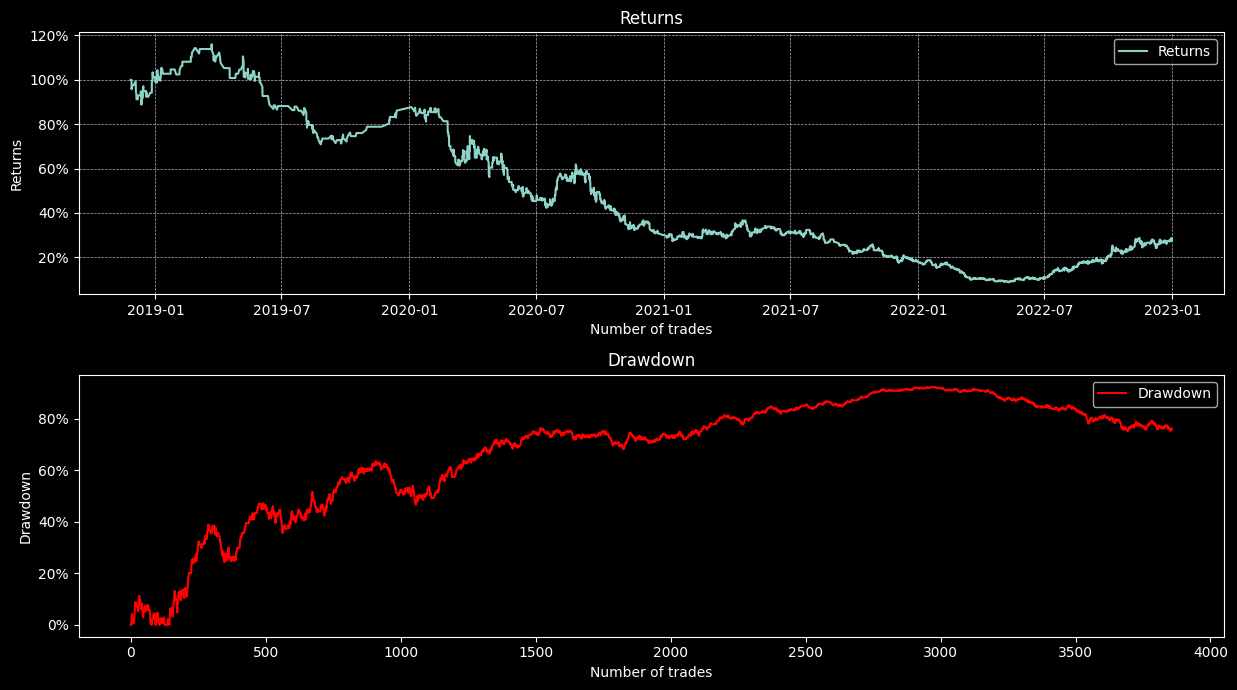

Metric                    Value
------------------------  -------------------------
Winrate overall           51.2%
Buy threshold             65.00%
R per trade               1.0
Winrate to break even     50%
Return                    28%
Max drawdown              92%
Paid fees                 176.25%
Number of trades overall  1657
% of traded setups        43%
Return to max drawdown    -0.8
Average transaction time  0 days 00:53:30.488835244
--------------------------------  -------------------
First trade                       2018-11-26 17:00:00
Last trade                        2022-12-30 17:40:00
Period of trading                 49.12 months
Number of trades overall per day  1.61
--------------------------------  -------------------


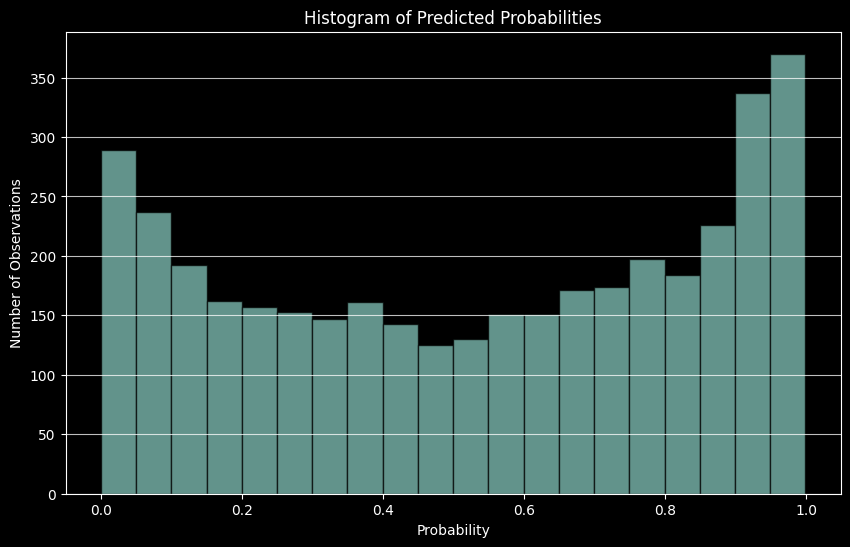

----------------  -------
Model type        xgboost
Max depth         6
N estimators      100
Min child weight  1
Learning rate     0.3
Buy threshold     65.00%
----------------  -------


In [ ]:
whole_model = False
lookback_period = 400
min_risk, max_risk = 0.02, 0.02
R_per_trade = float(R)
wr_to_break_even = 1/(1+R_per_trade)
buy_threshold = wr_to_break_even*1.3
max_risk_at = buy_threshold*1.25
spread = 1.2
slippage = 0.2
model_type = 'xgboost'
max_depth = 6
n_estimators = 100
min_child_weight = 1
learning_rate = 0.3
min_samples_split = 2

strategy_results(df, columns_to_test, time_column, exit_time, take_profit, lookback_period, whole_model, buy_threshold, max_risk_at, min_risk, max_risk, R_per_trade, spread,slippage, wr_to_break_even, model_type, max_depth, n_estimators, min_child_weight, learning_rate, min_samples_split)

print(tabulate([
    ["Model type", model_type],
    ["Max depth", max_depth],
    ["N estimators", n_estimators],
    ["Min child weight", min_child_weight],
    ["Learning rate", learning_rate],
    ["Buy threshold", f"{buy_threshold*100:.2f}%"],
]))

The first XGBoost model we built shows poor performance, which could be due to several factors, such as overfitting and calibration issues caused by a high learning rate, as evident in the predictions histogram.

To address these issues, we can adjust the model parameters and incorporate additional data. We will train the model using the entire dataset, as machine learning models like XGBoost are highly prone to overfitting and require a larger number of observations. Additionally, shifting the starting point of the backtest will allow the model to learn more effectively before making any predictions.

To combat overfitting, we will reduce the maximum tree depth and increase the minimum child weight. To improve calibration, we will lower the learning rate. Given computational constraints, we may also reduce the number of estimators. Furthermore, to increase the sample size of trades, we will lower the buy threshold.

C:\Users\Maciek\AppData\Local\Temp\ipykernel_4532\1859880483.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'risk'] = interp_high[i]
C:\Users\Maciek\AppData\Local\Temp\ipykernel_4532\1859880483.py:144: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9788333333333333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'result'] = df.at[i-1, 'result'] * (1 - df.at[i, 'risk'] - df.at[i, 'risk'] * spread / df.at[i, 'tp_size'] - df.at[i, 'risk'] * slippage / df.at[i, 'tp_size'])


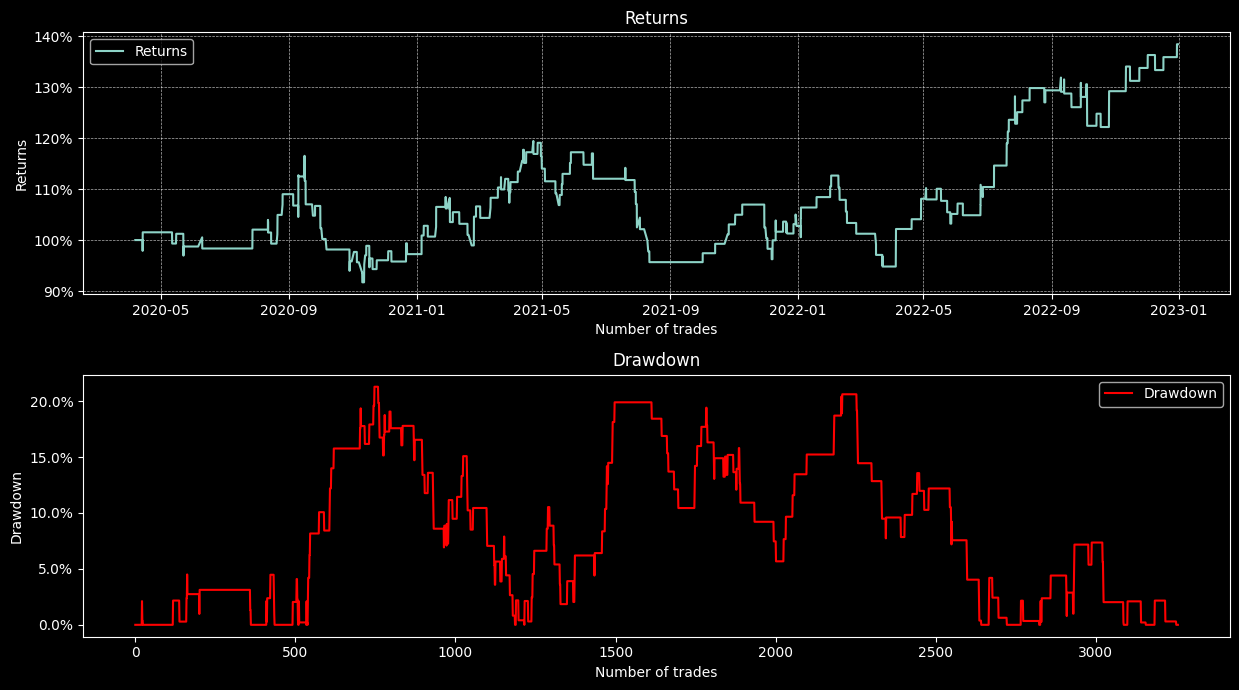

Metric                    Value
------------------------  -------------------------
Winrate overall           56.9%
Buy threshold             57.50%
R per trade               1.0
Winrate to break even     50%
Return                    138%
Max drawdown              21%
Paid fees                 26.93%
Number of trades overall  232
% of traded setups        7%
Return to max drawdown    1.8
Average transaction time  0 days 00:52:50.172413793
--------------------------------  -------------------
First trade                       2020-04-06 17:15:00
Last trade                        2022-12-30 17:40:00
Period of trading                 32.79 months
Number of trades overall per day  0.34
--------------------------------  -------------------


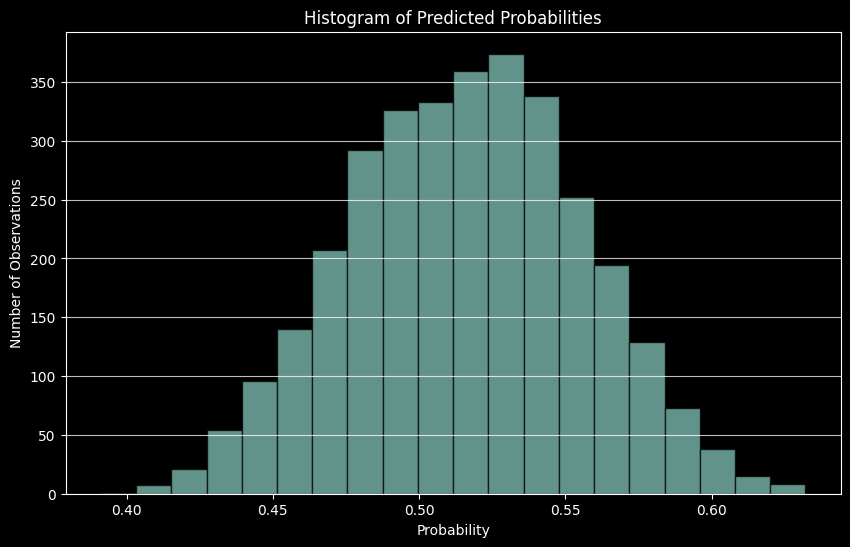

----------------  -------
Model type        xgboost
Max depth         4
N estimators      10
Min child weight  100
Learning rate     0.2
Buy threshold     57.50%
----------------  -------


In [ ]:
whole_model = True
lookback_period = 1000
min_risk, max_risk = 0.02, 0.02
R_per_trade = float(R)
wr_to_break_even = 1/(1+R_per_trade)
buy_threshold = wr_to_break_even*1.15
max_risk_at = buy_threshold*1.25
spread = 1.2
slippage = 0.2
model_type = 'xgboost'
max_depth = 4
n_estimators = 10
min_child_weight = 100
learning_rate = 0.2
min_samples_split = 2

strategy_results(df, columns_to_test, time_column, exit_time, take_profit, lookback_period, whole_model, buy_threshold, max_risk_at, min_risk, max_risk, R_per_trade, spread,slippage, wr_to_break_even, model_type, max_depth, n_estimators, min_child_weight, learning_rate, min_samples_split)

#print model variables in table
print(tabulate([
    ["Model type", model_type],
    ["Max depth", max_depth],
    ["N estimators", n_estimators],
    ["Min child weight", min_child_weight],
    ["Learning rate", learning_rate],
    ["Buy threshold", f"{buy_threshold*100:.2f}%"],
]))

The results of our next model are significantly better, but they lack consistency, with most of the profit being generated in the final few months of the backtesting period. Predictions could likely improve further if we addressed bias issues and refined our approach from the project's outset.

Comparing models is challenging due to their differing characteristics and the numerous parameters that can be adjusted. While grid search could be used to optimize these results, it also increases the risk of overfitting, which could severely impact the model's performance in a real-world production environment.

# Key Takeaways

Statistically Significant Variables: Identifying statistically significant variables can help predict market movement direction effectively.

Non-stationarity: Changing distributions of variables can lead to significant problems for models, causing them to make poor predictions. This issue must be addressed in the early stages of the project.

Profitalibity and statistical singificance: They are not necessarily correlated. While predictions may be strongly aligned with actual values, biases in the data can cause the model to fail miserably.

Variable Transformations: Using variables, their squared values, or their logarithms can be a powerful approach depending on the type of variable.

Different machine learning models: All of used models present unique challenges that must be addressed individually, with adjustments to data and parameters tailored to each model. Models that capture non-linear relationships require larger datasets for accurate predictions and are more prone to overfitting. They are also more computationally demanding, which can lead to delays in production due to the time required for their calculations.

Variable Interactions: Interactions between variables can be useful, especially for concepts like trend detection.

Model Considerations: Different models, whether calculated on the whole dataset or just a lookback period, have their advantages and disadvantages. Trend variables might provide better results for adjusting models, while concepts like support/resistance might be more effective in standard models.

Market Condition Adaptability: Some models tend to follow the general market direction and are only profitable in bullish markets, while others can bring profits under various market conditions.

Variable Usage: Each variable provides slight improvements to the model; therefore, the use of many variables is recommended.

Lookback Period Impact: Models with shorter lookback periods offer more transactions but at the cost of a decreased win rate, which can reduce profits and increase transaction costs.

Scaling Order Size: Adjusting order size based on the probability of trade might be beneficial for overall returns.

High R Variables: Using higher R variables as the target (Y) almost always yields better results. However, analyzing the average trade duration (which increases) may indicate this is due to a general bullish market trend.

Impact of Fees: Transaction fees significantly reduce strategy effectiveness and can often render strategies unprofitable.

Buy Threshold: Increasing the buy threshold might be beneficial in some cases, but generally does not increase returns, as the number of trades significantly decreases.

Algorithmic Trading Success: Algorithmic trading strategies can yield positive results if the selection of variables and other model parameters is done correctly.
